# Overfitting and Regularization

## Imports

In [522]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [523]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [524]:
set_config(display='diagram')

## Settings

In [525]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)
len(ALPHAS)

41

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [526]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

In [527]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

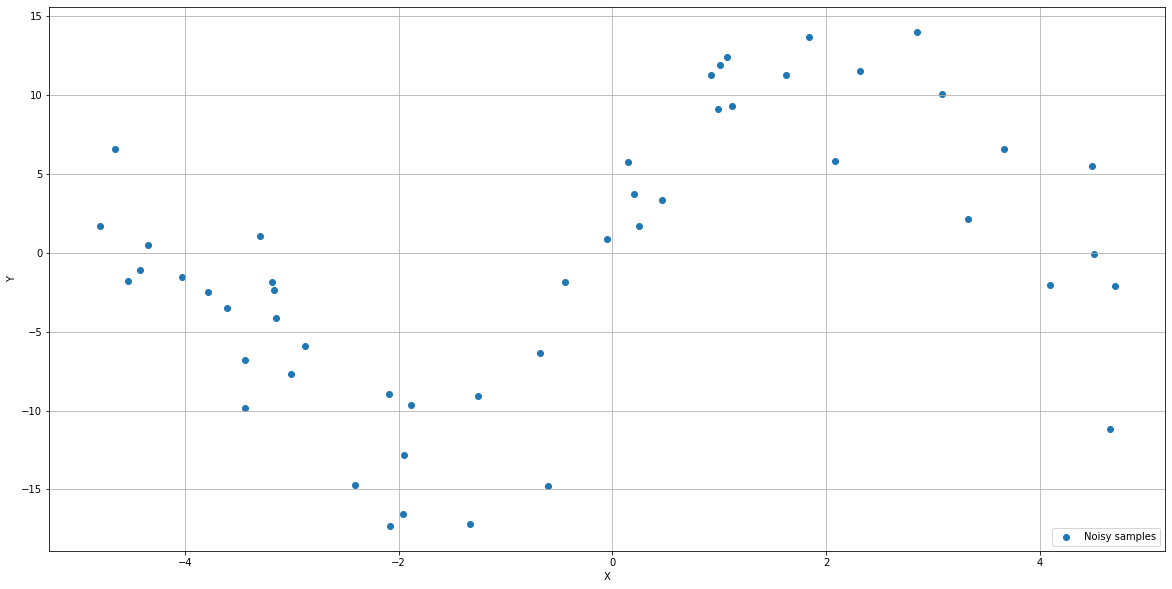

In [528]:
def plot_scatter(x, y, title=None,xlabel='X',ylabel='Y', label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.figure(figsize=(20, 10))
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')
    plt.rcParams["figure.figsize"] = (20,10)
    

plot_scatter(X, y)

### Split

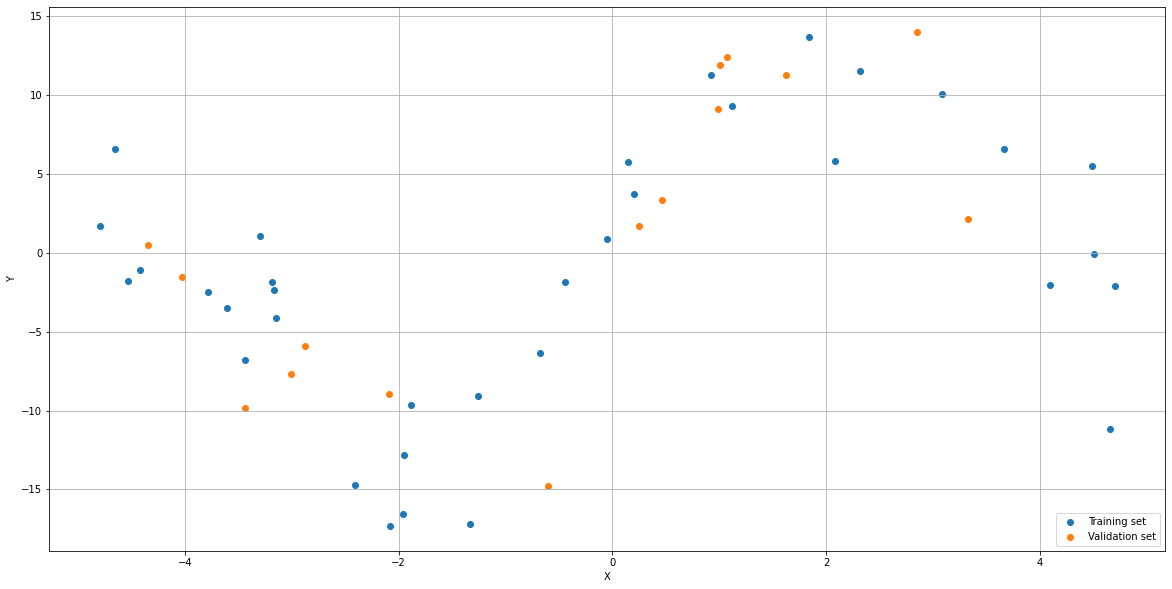

In [529]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [530]:
PolynomialFeatures(degree=4).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.,   1.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

In [531]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression(fit_intercept=False)
    
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    # ridge regression
    elif penalty == 'L2':
        regressor = Ridge(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg', LinearRegression(fit_intercept=False))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Lasso(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Ridge(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

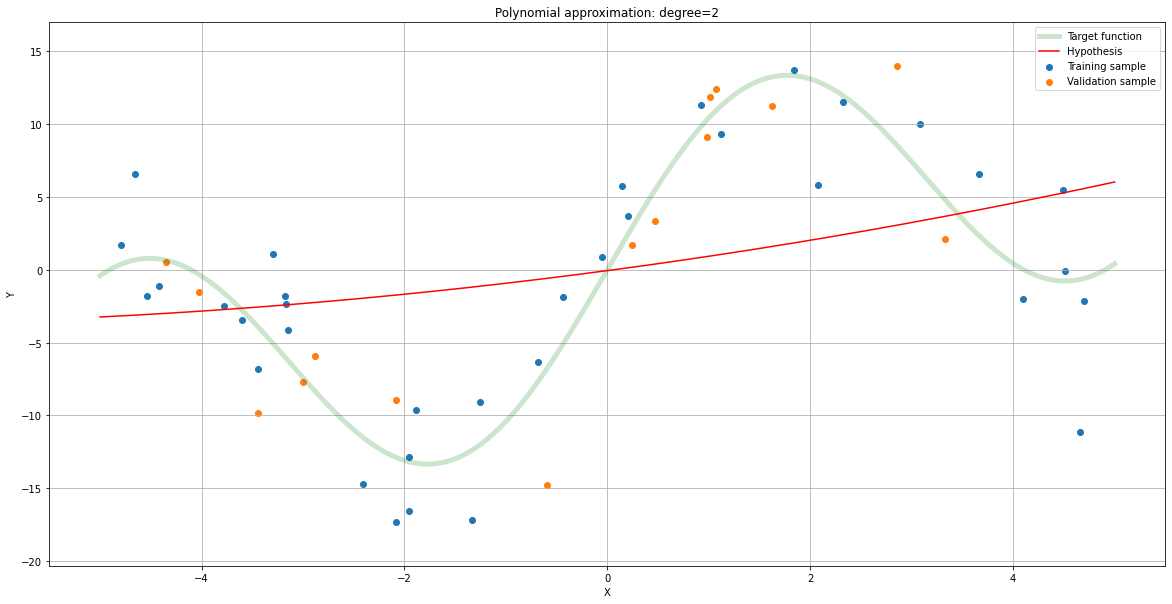

In [532]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

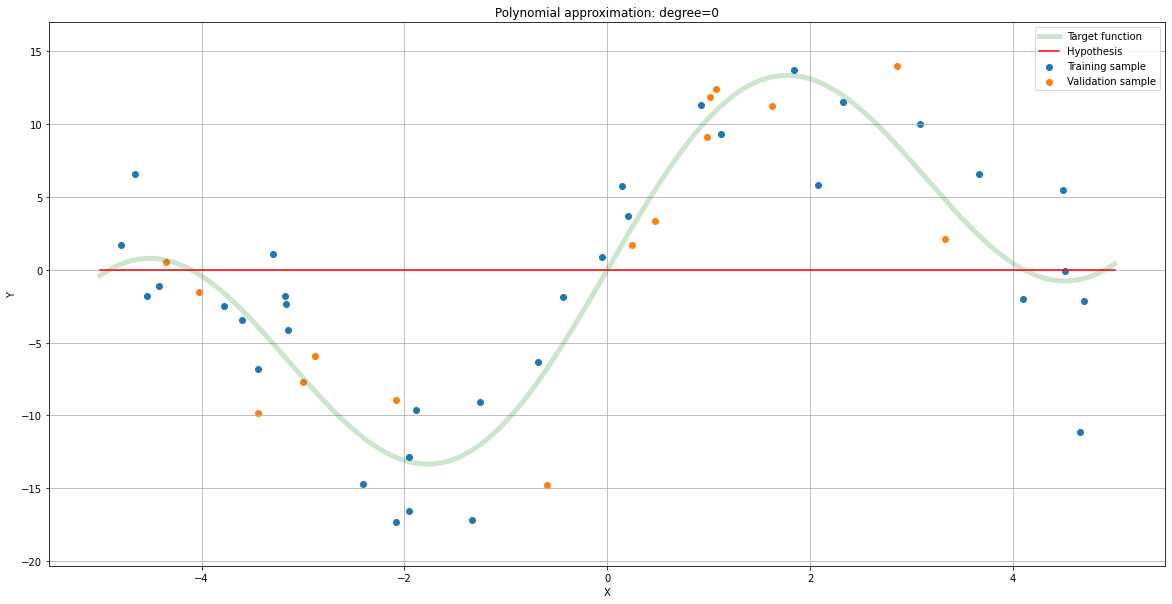

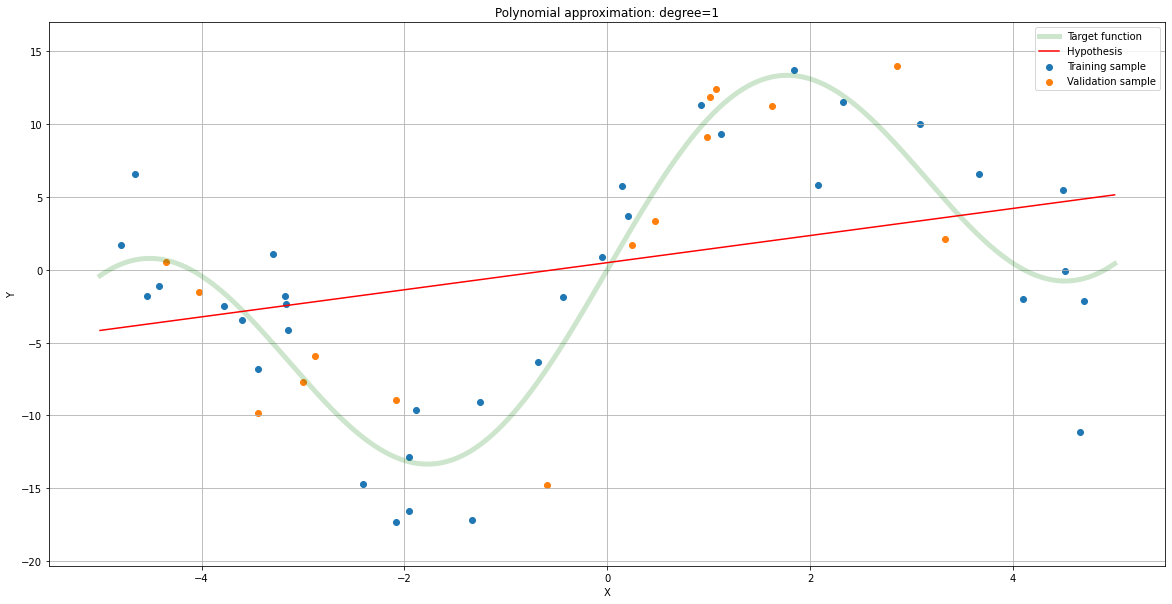

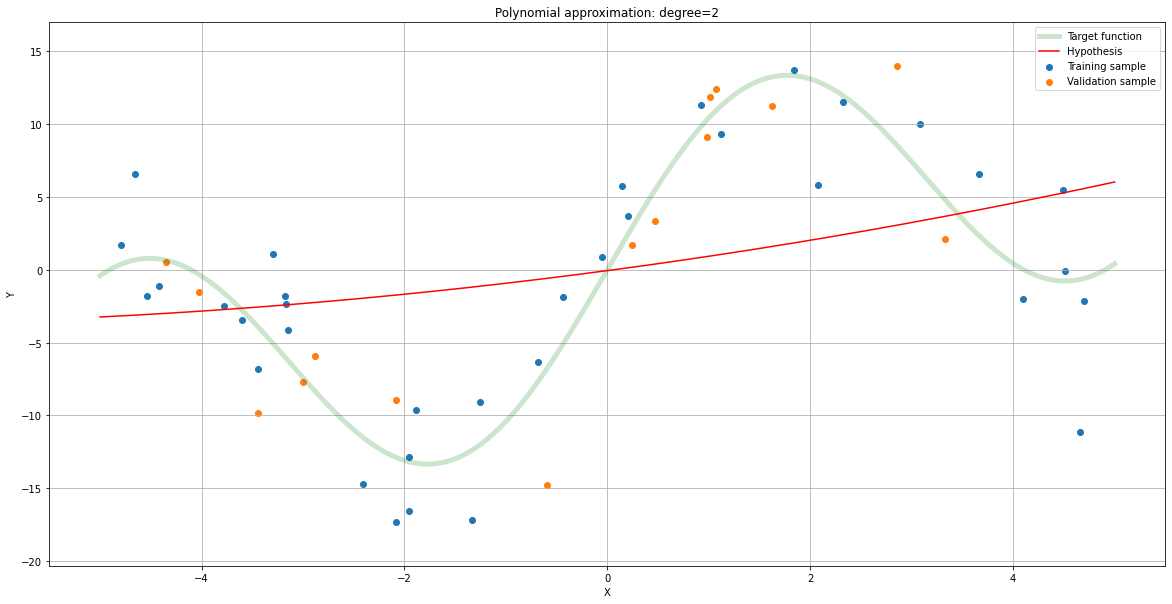

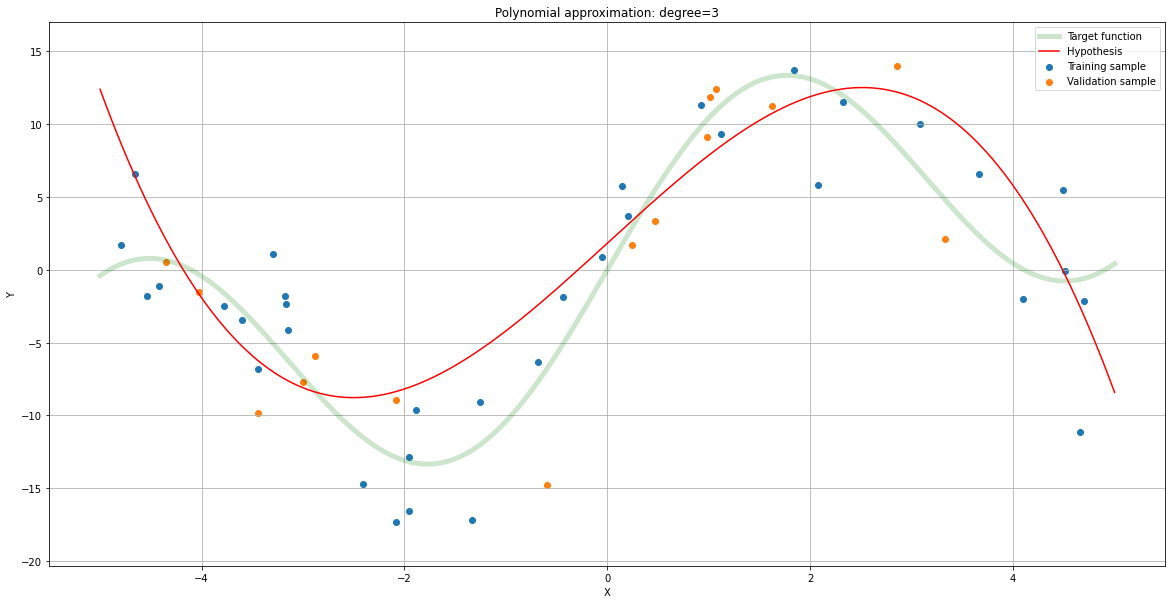

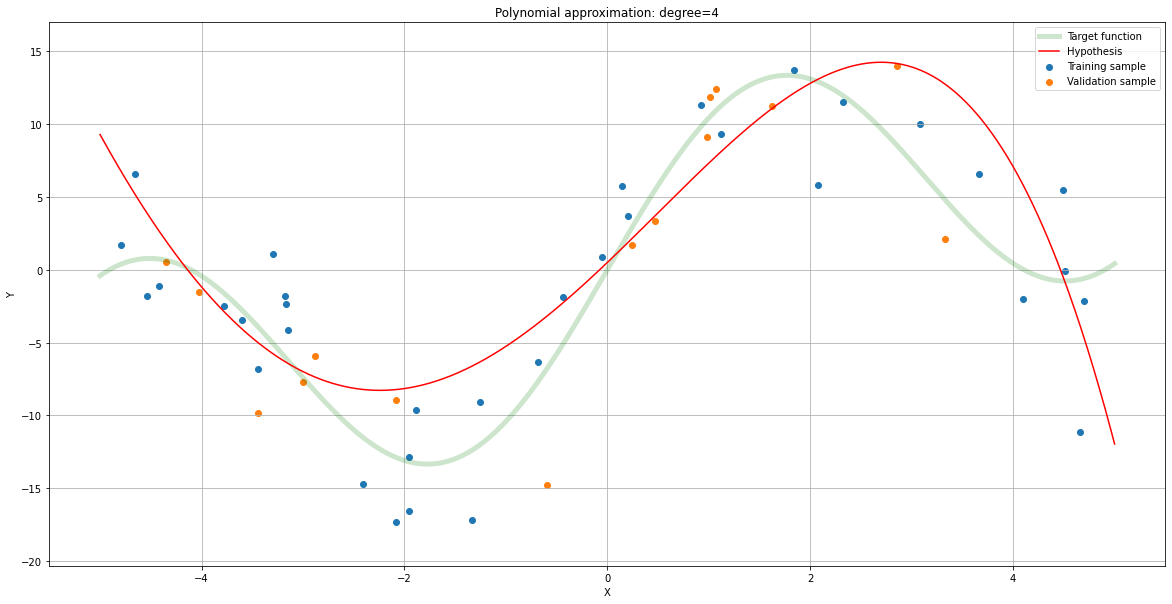

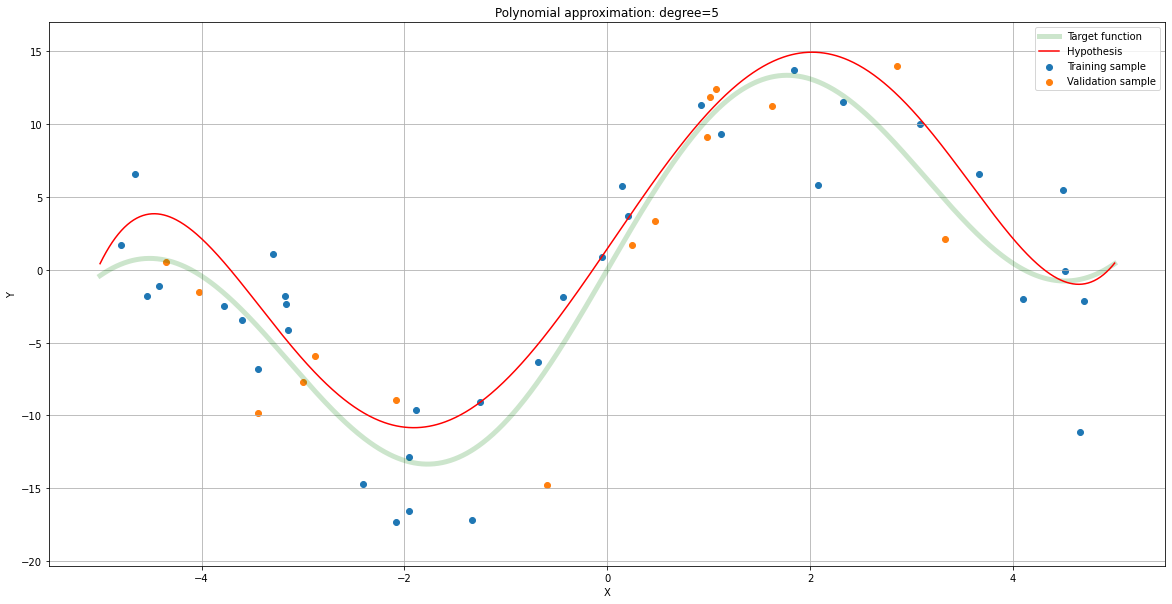

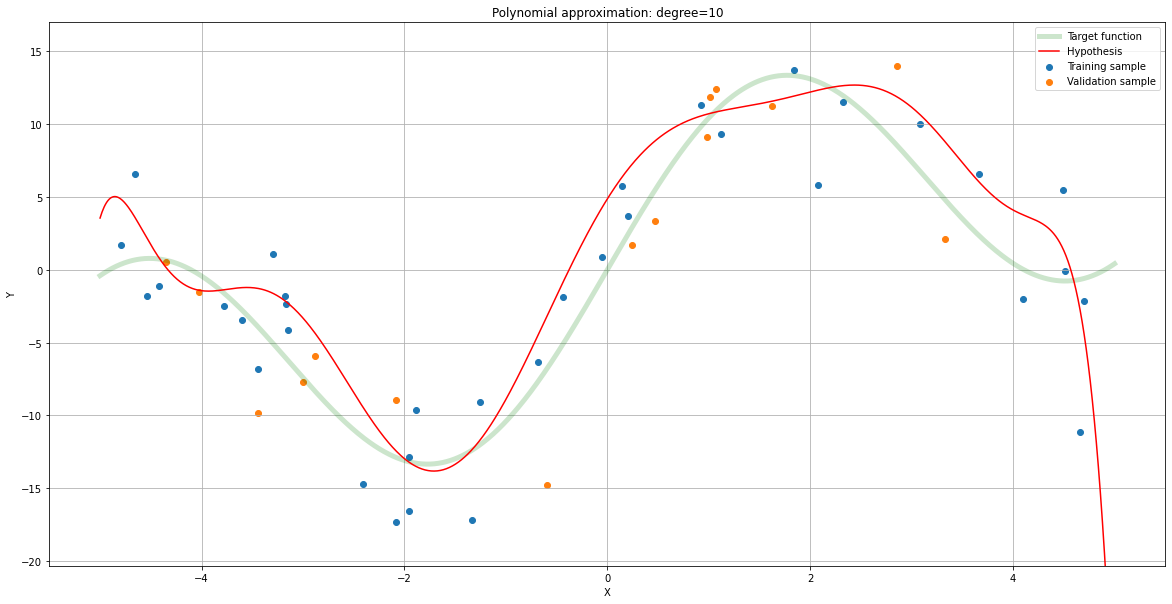

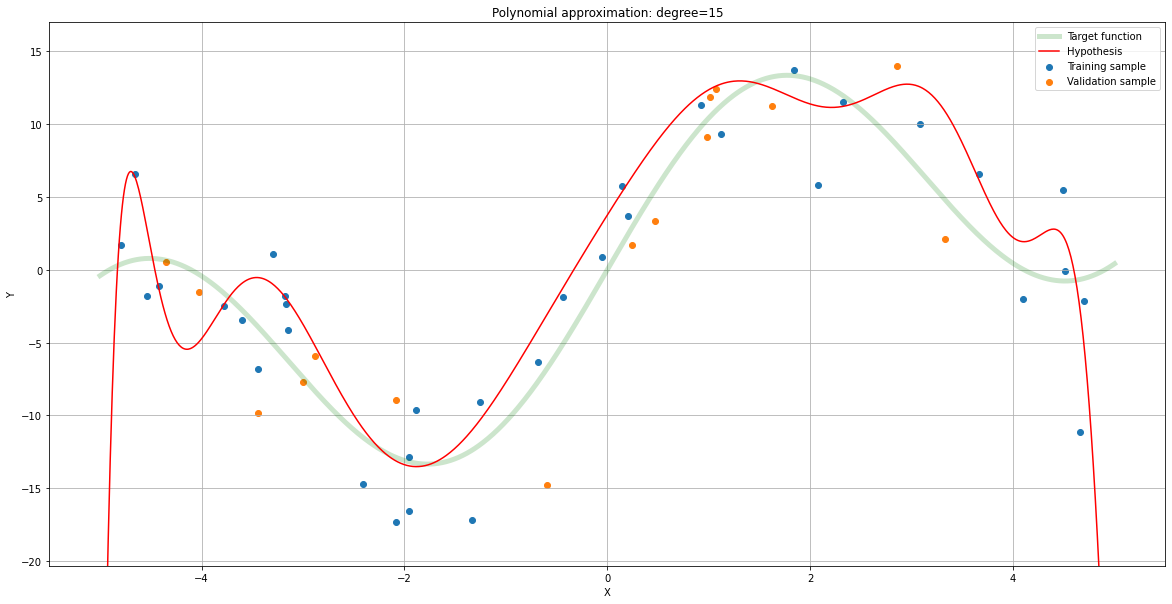

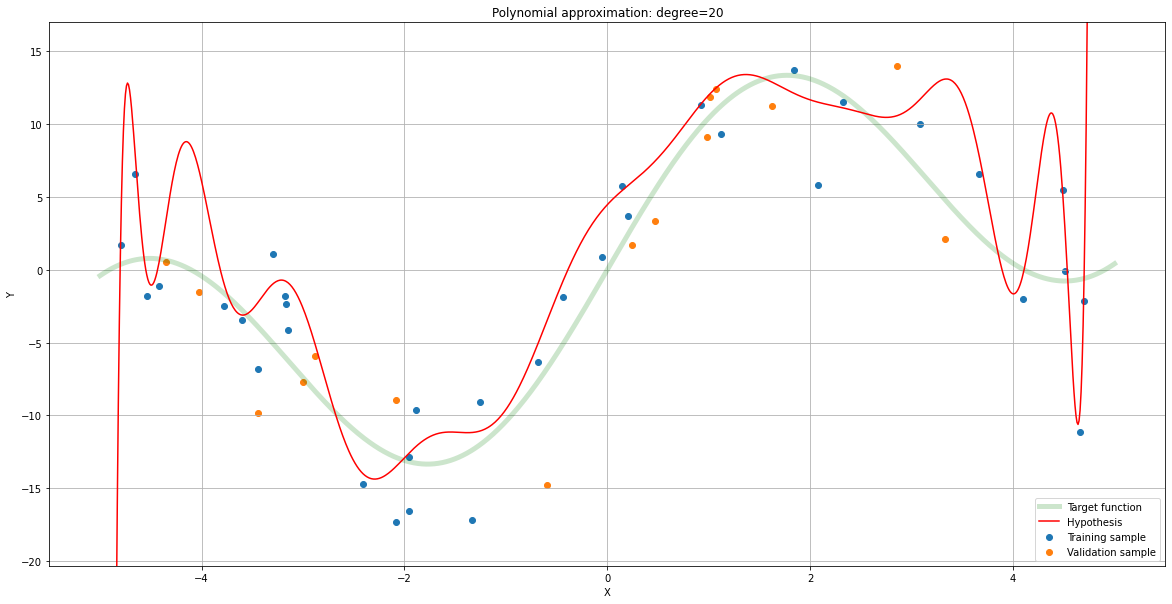

In [533]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

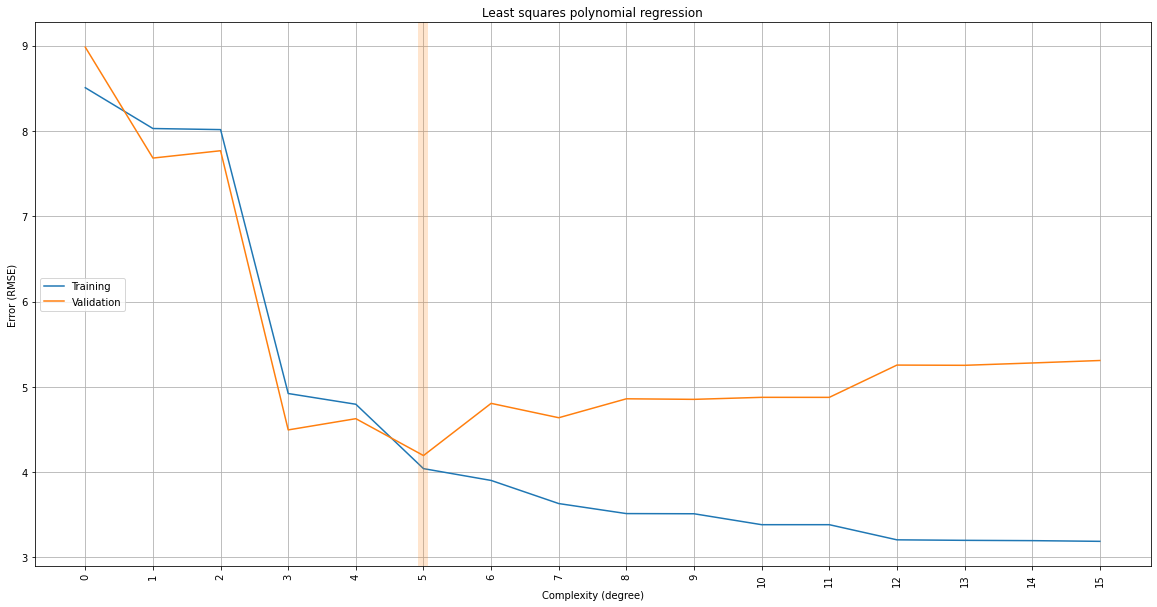

In [534]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    #plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [535]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

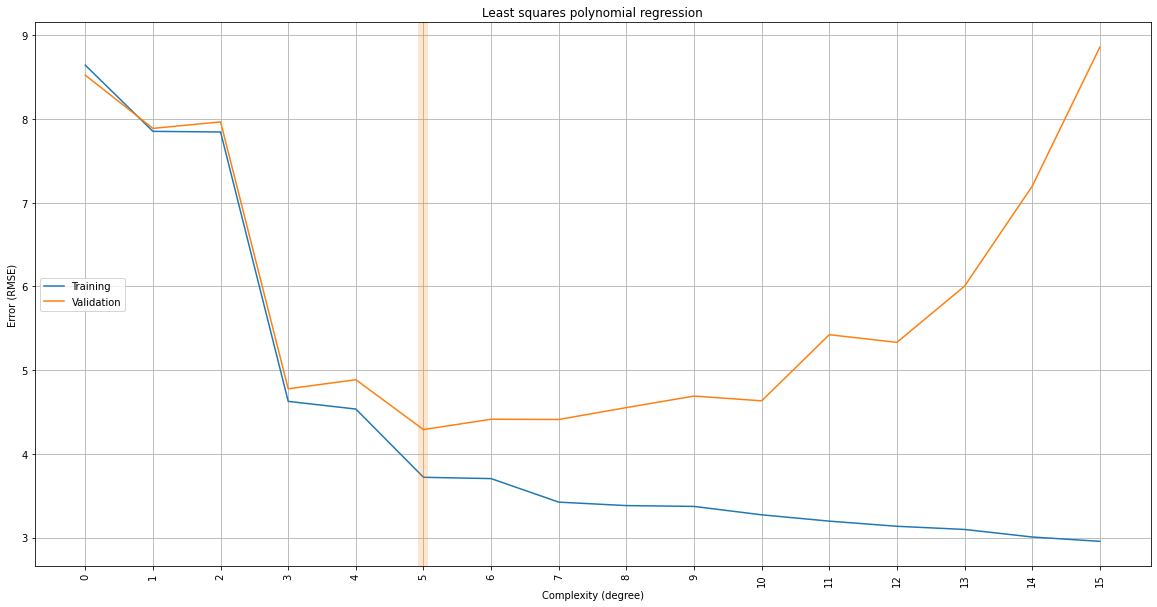

In [536]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
   # print(str(degree)+" "+"train "+str(results['train_score']))
   # print(str(degree)+" "+"test "+str(results['test_score']))
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [537]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([0.        , 2.81292778]),
 array([0.        , 2.80049884, 0.45166501]),
 array([  0.        ,  30.87315584,   1.48752361, -54.60227825,
         -1.63699842,  26.62792933]),
 array([   0.        ,   33.63850705,  -41.86346242,  -70.48743112,
         278.98853452,   27.48125634, -656.36383501,   59.32988346,
         651.64795186,  -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

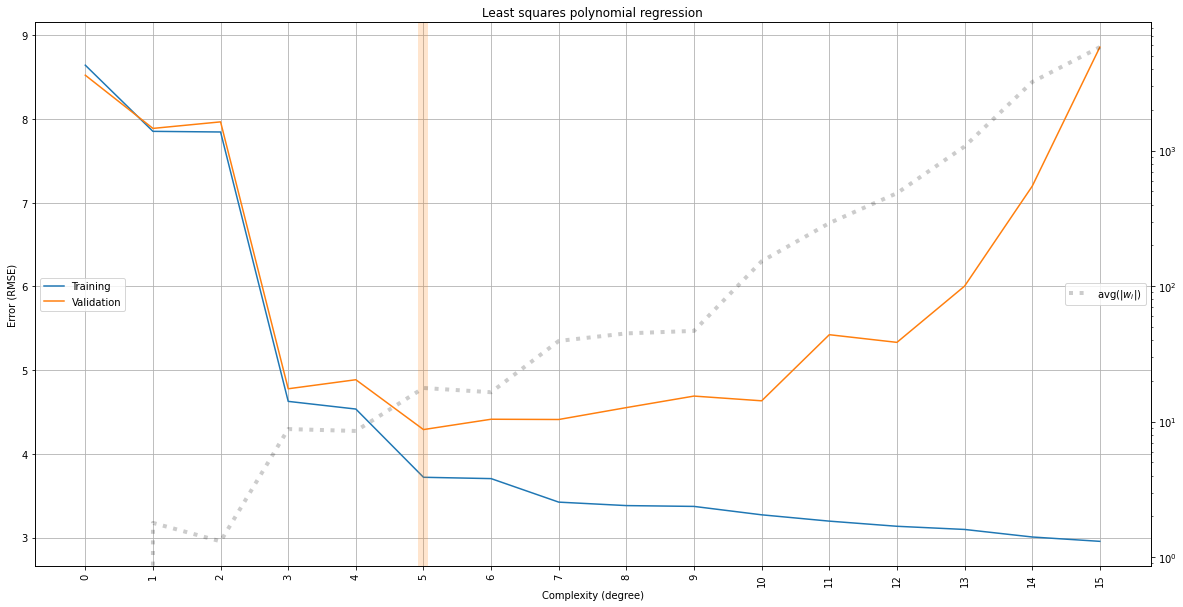

In [538]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_)) for model in results['estimator'] ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

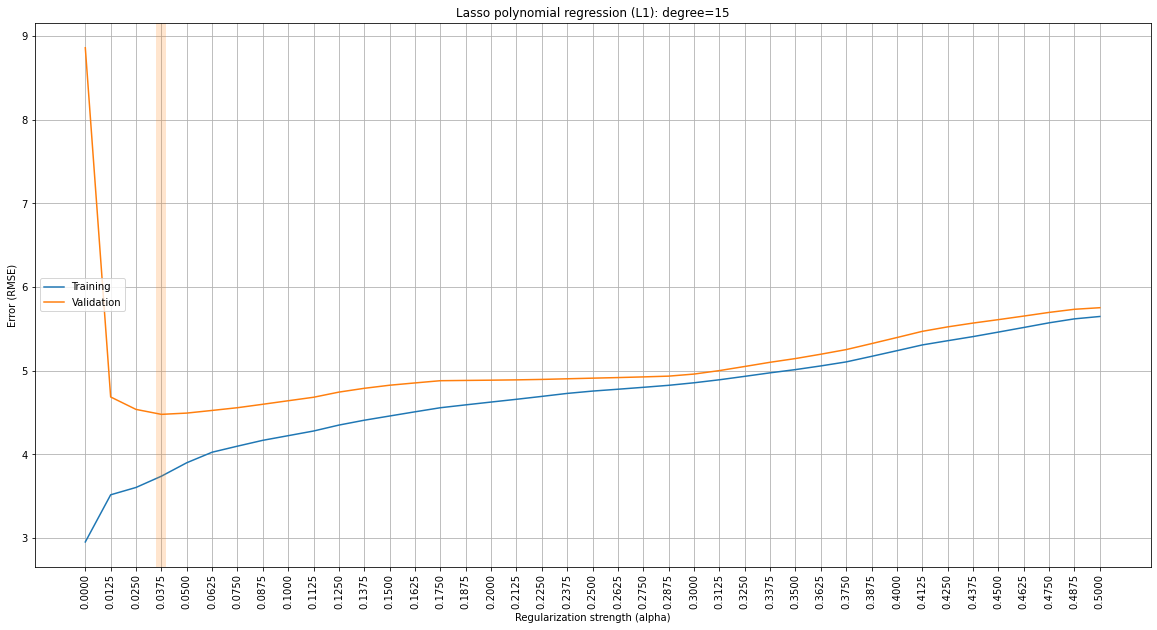

In [539]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

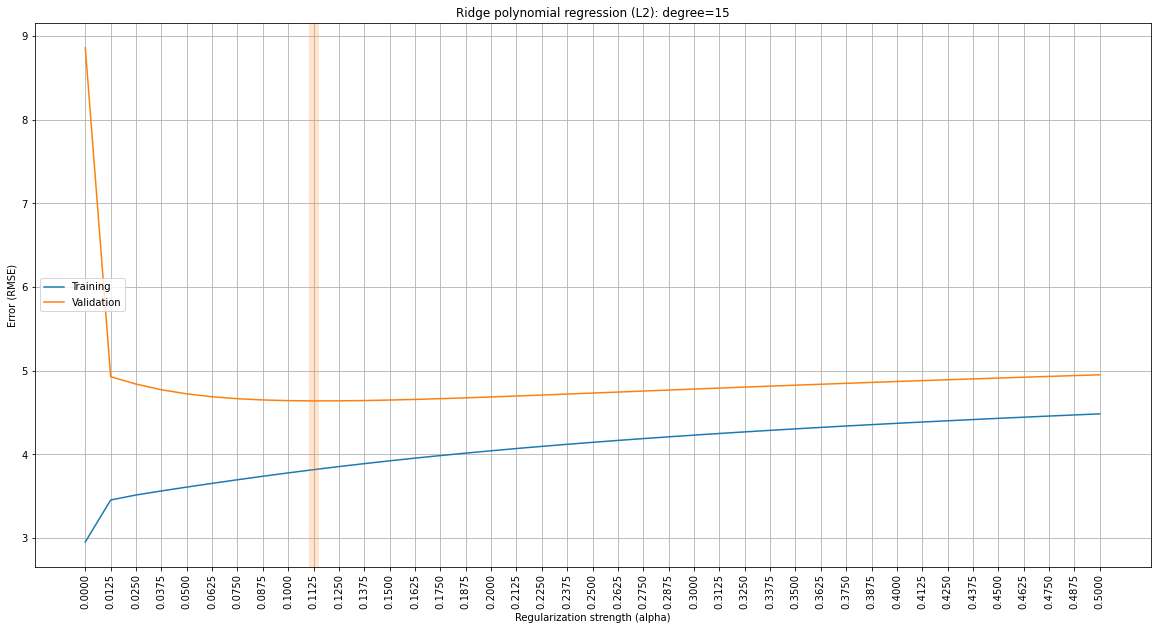

In [540]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Magnitude (4 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

In [541]:
def plot_graph(x, coef_lines, xlabel, ylabel, label, custom_scale='linear', title='Fitting graph'):
    plt.figure(figsize=(20, 10))
    for i in range(0,len(coef_lines)):
        plt.plot(x, coef_lines[i], label=label+str(i))
    plt.title(title)
    plt.yscale(custom_scale)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center right')   
    
def plot_fit_optimal(Y_res, title, xlabel, ylabel, min_y=(min(y)-100), max_y=(max(y)+100)):
    plot_scatter(X, y, label='All Data')
    plt.scatter(X, Y_res, c='red', label='Hypothesis')
    plt.ylim(min_y, max_y)
    plt.legend(loc='best')    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()


,Value
Training score,2.954768
Validation score,8.859732


,Value
0,0.000000
1,40.993316
2,8.294028
3,-199.327724
4,-331.102612
5,738.180635
6,2597.485587
7,-1262.498212
8,-8289.899532
9,-376.294618


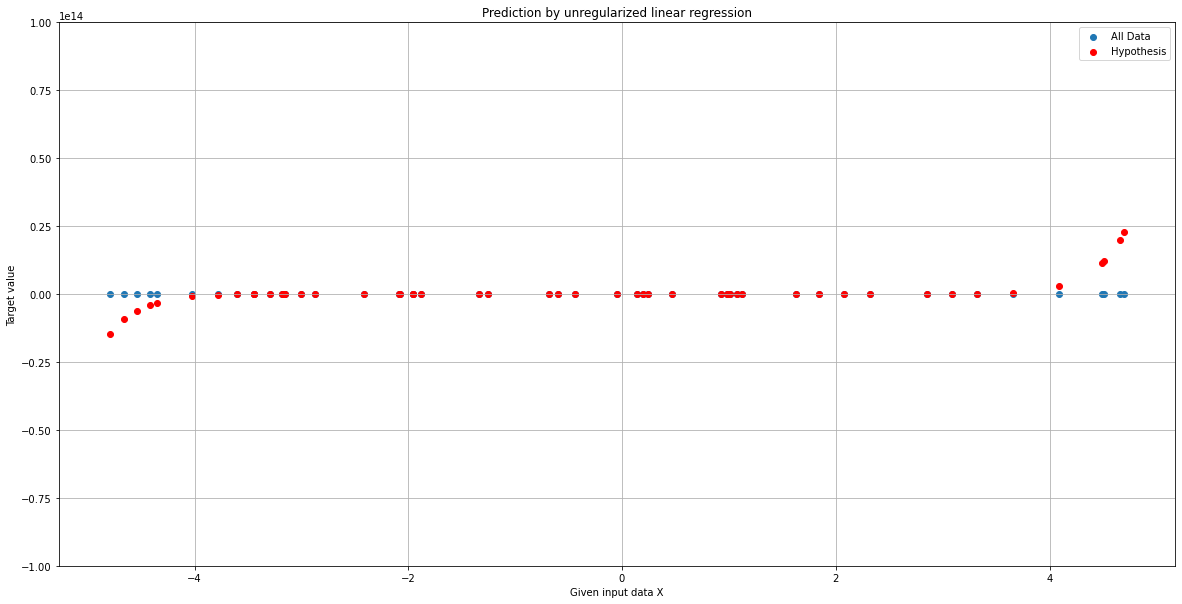

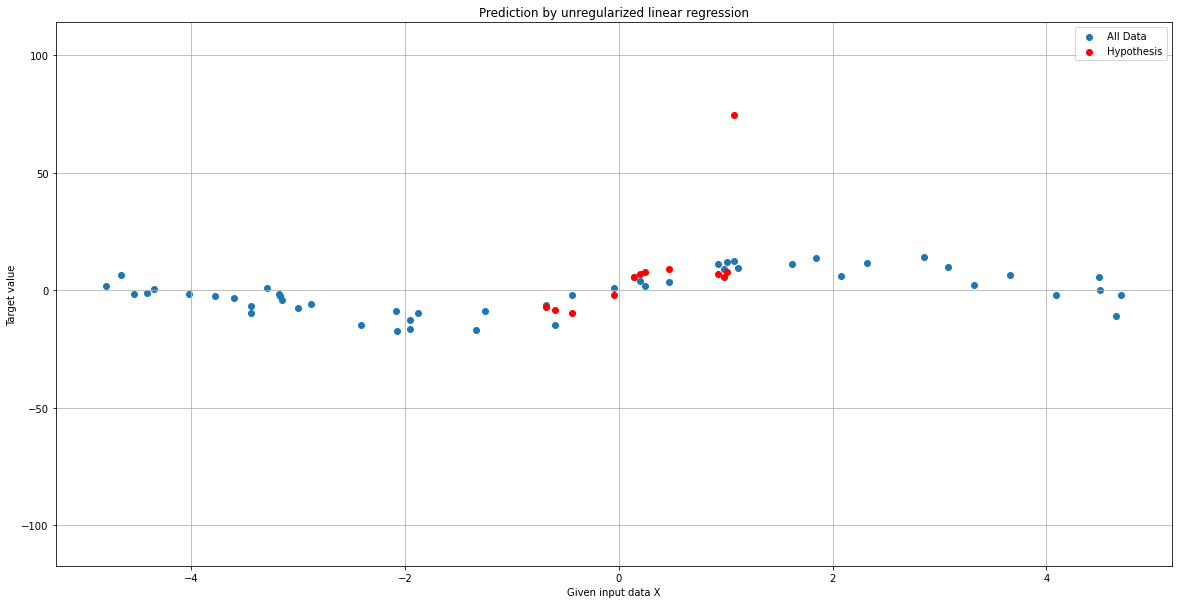

In [542]:
#without regularization
#rmse_trainL, rmse_validL, 
avg_coefL = []
results = cross_validate(make_model(degree=15), 
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
rmse_trainL=(abs(np.mean(results['train_score'])))
rmse_validL=(abs(np.mean(results['test_score'])))
help=[]
for i in np.arange(0,16):
    help.append(np.mean([(model['reg'].coef_[i]) for model in results['estimator']]))
avg_coefL=help

df = pd.DataFrame(data=[rmse_trainL,rmse_validL],index=['Training score','Validation score'],columns=['Value'])
display(df)


y_opt = np.empty(len(X), dtype=float)

for i in np.arange(0,len(X)):
    for deg in np.arange(0,len(avg_coefL)):
         y_opt[i] = y_opt[i] + avg_coefL[deg]*pow(X[i], deg)

df = pd.DataFrame(data=avg_coefL,index=np.arange(0,16),columns=['Value'])
display(df)

plot_fit_optimal(y_opt, title='Prediction by unregularized linear regression',xlabel='Given input data X',
                 ylabel='Target value',min_y=-100000000000000, max_y=+100000000000000)# - best approximation

plot_fit_optimal(y_opt, title='Prediction by unregularized linear regression',xlabel='Given input data X',
                 ylabel='Target value')# - best approximation, closer


#### L1

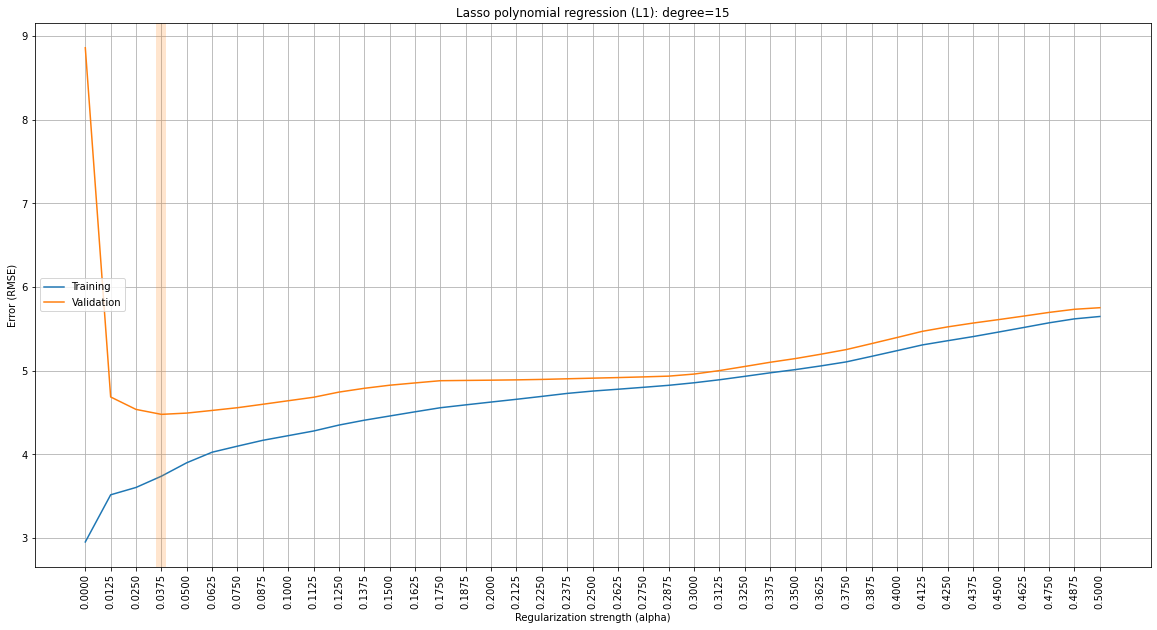

,0.0000,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,40.993316,28.840109,27.078698,25.324386,23.635303,22.359730,21.498759,20.727671,20.107391,19.526687,18.892735,18.370708,17.926850,17.508259,17.121594,16.841450,16.574741,16.318323,16.060570,15.806732,15.598879,15.424819,15.250770,15.076659,14.853751,14.576317,14.260596,13.945169,13.664374,13.349046,13.014555,12.556846,12.098167,11.639384,11.315461,11.003119,10.660076,10.315808,9.971649,9.685313,9.516756
2,8.294028,0.428966,0.584729,0.700914,0.637224,0.601035,0.561485,0.525817,0.487097,0.450518,0.421405,0.387279,0.353134,0.317584,0.282418,0.231733,0.208517,0.188096,0.167214,0.146473,0.122618,0.092192,0.061754,0.031315,0.005900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-199.327724,-43.538549,-38.581447,-33.616367,-28.774559,-25.284687,-23.267756,-21.567697,-20.398442,-19.352018,-18.124087,-17.214522,-16.496164,-15.831667,-15.225880,-14.861443,-14.501182,-14.167587,-13.835144,-13.508307,-13.267986,-13.097408,-12.926842,-12.756220,-12.424641,-11.906079,-11.260076,-10.614711,-10.070454,-9.424862,-8.724342,-7.637617,-6.548063,-5.458151,-4.757733,-4.094993,-3.323629,-2.549064,-1.774516,-1.167330,-0.899074
4,-331.102612,0.628747,0.285368,0.001363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,738.180635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.117393,-0.372226,-0.720392,-1.068187,-1.346204,-1.694296,-2.080356,-2.746004,-3.413606,-4.081476,-4.481484,-4.855139,-5.311878,-5.770729,-6.229656,-6.573021,-6.682313
6,2597.485587,-0.409635,-0.388065,-0.262504,-0.037697,0.000000,0.000000,-0.003082,-0.006410,-0.004733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,-1262.498212,25.106773,20.162863,14.699659,8.291724,3.514833,1.225810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,-8289.899532,0.000000,0.000000,-0.081327,-0.246238,-0.263770,-0.249524,-0.238934,-0.078975,-0.003671,-0.006779,-0.006939,-0.006110,-0.005160,-0.004821,-0.004570,-0.004240,-0.003906,-0.003574,-0.003235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,-376.294618,1.990993,0.561569,0.000000,1.116673,2.615593,3.561968,3.080435,2.036737,1.457019,0.404559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

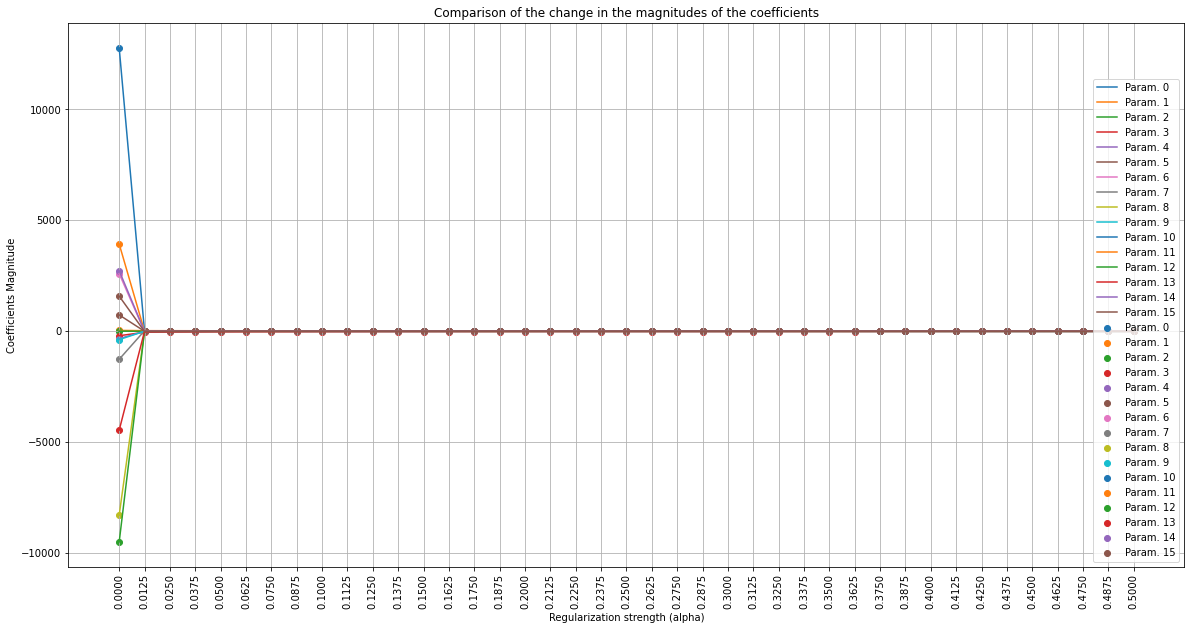

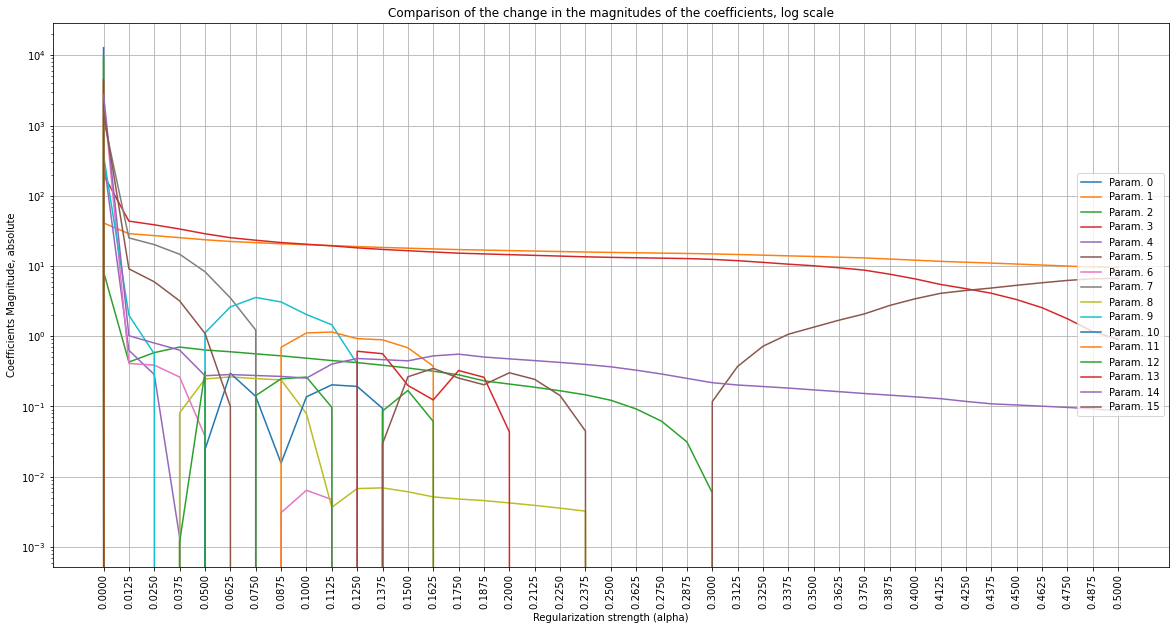

In [543]:
rmse_trainL1, rmse_validL1, avg_coefL1 = [], [],[]
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_trainL1.append(abs(np.mean(results['train_score'])))
    rmse_validL1.append(abs(np.mean(results['test_score'])))
    help=[]
    for i in np.arange(0,16):
        help.append(np.mean([(model['reg'].coef_[i]) for model in results['estimator']]))
    avg_coefL1.append(help)
        
              
plot_fitting_graph(ALPHAS, rmse_trainL1, rmse_validL1,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

avg_coefL1=np.transpose(avg_coefL1)
plot_graph(ALPHAS, avg_coefL1, title="Comparison of the change in the magnitudes of the coefficients, linear scale", xlabel='Regularization strength (alpha)',
           ylabel='Coefficients Magnitude', label='Param. ')  

for i in range(0,len(avg_coefL1)):
    plot_scatter(ALPHAS, avg_coefL1[i], title="Comparison of the change in the magnitudes of the coefficients", xlabel='Regularization strength (alpha)',ylabel='Coefficients Magnitude',
             label='Param. '+str(i))
plot_graph(ALPHAS, abs(avg_coefL1), title="Comparison of the change in the magnitudes of the coefficients, log scale",
           xlabel='Regularization strength (alpha)', ylabel='Coefficients Magnitude, absolute', label='Param. ',custom_scale='log')   

df1 = pd.DataFrame(data=avg_coefL1, index=np.arange(0,16), columns=ALPHAS.round(4))
display(df1)


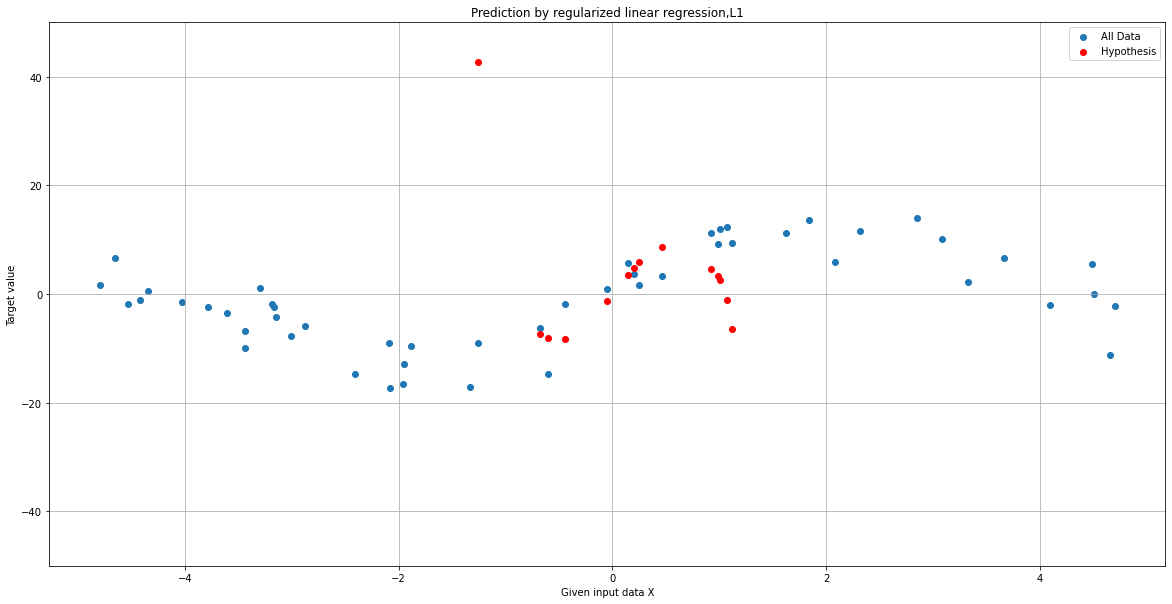

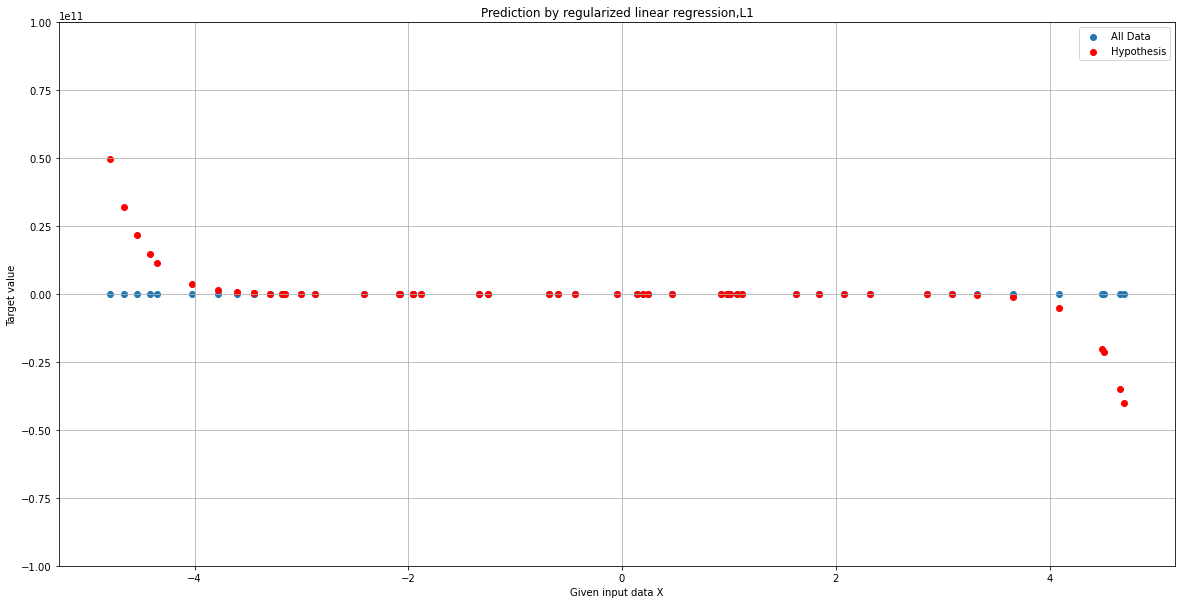

In [544]:
y_opt = np.empty(len(X), dtype=float)

for i in np.arange(0,len(X)):
    for deg in np.arange(0,len(avg_coefL1)):
         y_opt[i] = y_opt[i] + avg_coefL1[:,3][deg]*pow(X[i], deg)
            

plot_fit_optimal(y_opt, title='Prediction by regularized linear regression,L1',xlabel='Given input data X',
                 ylabel='Target value',min_y=-50, max_y=+50)# - best approximation

plot_fit_optimal(y_opt, title='Prediction by regularized linear regression,L1',xlabel='Given input data X',
                 ylabel='Target value',min_y=-100000000000, max_y=+100000000000)# - best approximation, closer


#### L2

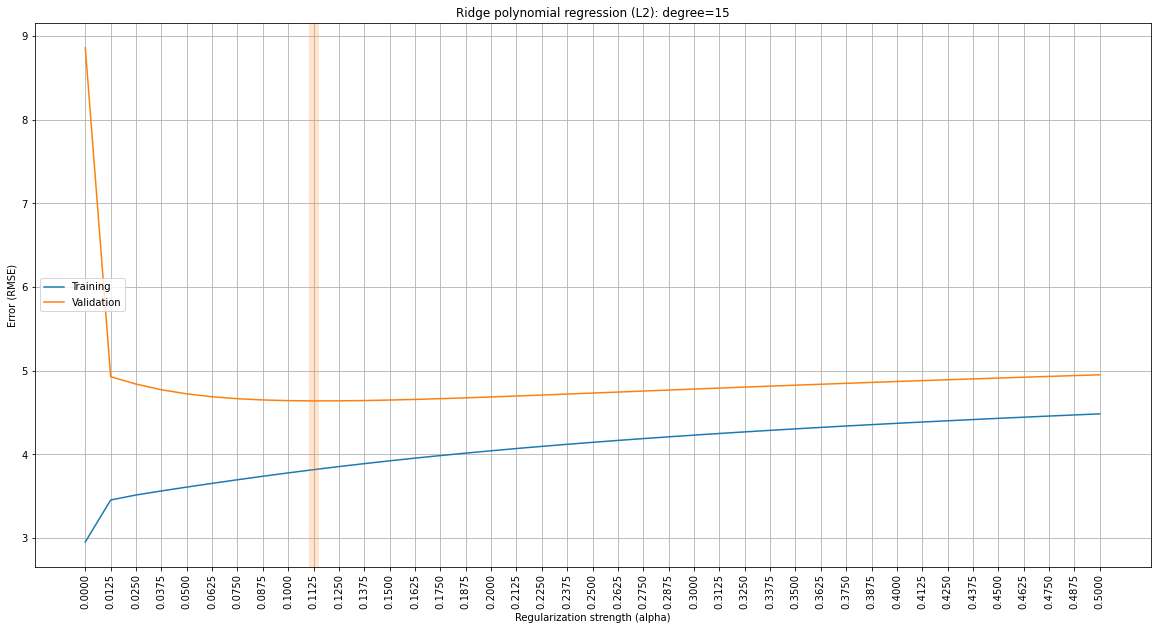

,0.0000,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,40.993316,29.418257,27.906882,26.863814,26.029291,25.322956,24.707427,24.161187,23.670205,23.224589,22.816992,22.441756,22.094405,21.771324,21.469551,21.186619,20.920456,20.669304,20.431656,20.206216,19.991857,19.787597,19.592572,19.406023,19.227274,19.055728,18.890847,18.732154,18.579215,18.431642,18.289082,18.151216,18.017752,17.888425,17.762992,17.641231,17.522937,17.407922,17.296013,17.187049,17.080882
2,8.294028,-1.282098,-0.876043,-0.704703,-0.577266,-0.467142,-0.368778,-0.280442,-0.201167,-0.130134,-0.066561,-0.009708,0.041120,0.086559,0.127185,0.163516,0.196013,0.225086,0.251100,0.274377,0.295203,0.313833,0.330491,0.345379,0.358673,0.370532,0.381099,0.390498,0.398845,0.406238,0.412771,0.418523,0.423568,0.427973,0.431797,0.435094,0.437912,0.440295,0.442284,0.443913,0.445217
3,-199.327724,-46.467914,-40.304757,-36.681081,-34.027778,-31.905161,-30.128081,-28.599129,-27.259410,-26.069865,-25.002873,-24.037978,-23.159506,-22.355120,-21.614914,-20.930795,-20.296062,-19.705101,-19.153160,-18.636185,-18.150689,-17.693653,-17.262446,-16.854766,-16.468584,-16.102108,-15.753745,-15.422075,-15.105829,-14.803867,-14.515160,-14.238782,-13.973893,-13.719729,-13.475596,-13.240859,-13.014939,-12.797304,-12.587465,-12.384974,-12.189416
4,-331.102612,7.512246,5.230989,4.486555,4.076637,3.785819,3.552830,3.354921,3.181753,3.027744,2.889418,2.764361,2.650755,2.547160,2.452395,2.365465,2.285524,2.211840,2.143780,2.080787,2.022374,1.968109,1.917611,1.870540,1.826595,1.785506,1.747030,1.710950,1.677072,1.645217,1.615228,1.586960,1.560282,1.535076,1.511232,1.488653,1.467249,1.446936,1.427640,1.409291,1.391826
5,738.180635,5.994204,0.473271,-1.796118,-3.041783,-3.828722,-4.368591,-4.759225,-5.052361,-5.278061,-5.455060,-5.595681,-5.708384,-5.799186,-5.872492,-5.931606,-5.979056,-6.016816,-6.046447,-6.069203,-6.086100,-6.097977,-6.105524,-6.109322,-6.109858,-6.107546,-6.102738,-6.095739,-6.086810,-6.076178,-6.064040,-6.050570,-6.035918,-6.020219,-6.003591,-5.986139,-5.967955,-5.949123,-5.929716,-5.909801,-5.889438
6,2597.485587,-7.575867,-3.897708,-2.671295,-2.081608,-1.743943,-1.528524,-1.380108,-1.271570,-1.188232,-1.121573,-1.066376,-1.019306,-0.978163,-0.941449,-0.908124,-0.877448,-0.848888,-0.822051,-0.796644,-0.772446,-0.749289,-0.727041,-0.705599,-0.684883,-0.664826,-0.645375,-0.626487,-0.608125,-0.590258,-0.572860,-0.555908,-0.539383,-0.523266,-0.507543,-0.492197,-0.477218,-0.462592,-0.448308,-0.434356,-0.420727
7,-1262.498212,16.230450,13.402855,11.588223,10.215454,9.102255,8.166034,7.360883,6.657825,6.036982,5.483919,4.987723,4.539894,4.133657,3.763515,3.424939,3.114157,2.827992,2.563743,2.319098,2.092064,1.880911,1.684132,1.500403,1.328559,1.167570,1.016521,0.874595,0.741063,0.615271,0.496630,0.384608,0.278725,0.178544,0.083668,-0.006262,-0.091579,-0.172583,-0.249550,-0.322736,-0.392374
8,-8289.899532,-2.945252,-2.332695,-2.223052,-2.185275,-2.156545,-2.125212,-2.089890,-2.051372,-2.010744,-1.968934,-1.926653,-1.884417,-1.842592,-1.801432,-1.761108,-1.721731,-1.683373,-1.646071,-1.609841,-1.574684,-1.540590,-1.507539,-1.475508,-1.444470,-1.414394,-1.385249,-1.357004,-1.329626,-1.303085,-1.277350,-1.252390,-1.228176,-1.204680,-1.181874,-1.159733,-1.138231,-1.117344,-1.097050,-1.077324,-1.058148
9,-376.294618,10.053670,11.203862,11.027205,10.539561,9.974753,9.407297,8.863872,8.353696,7.87

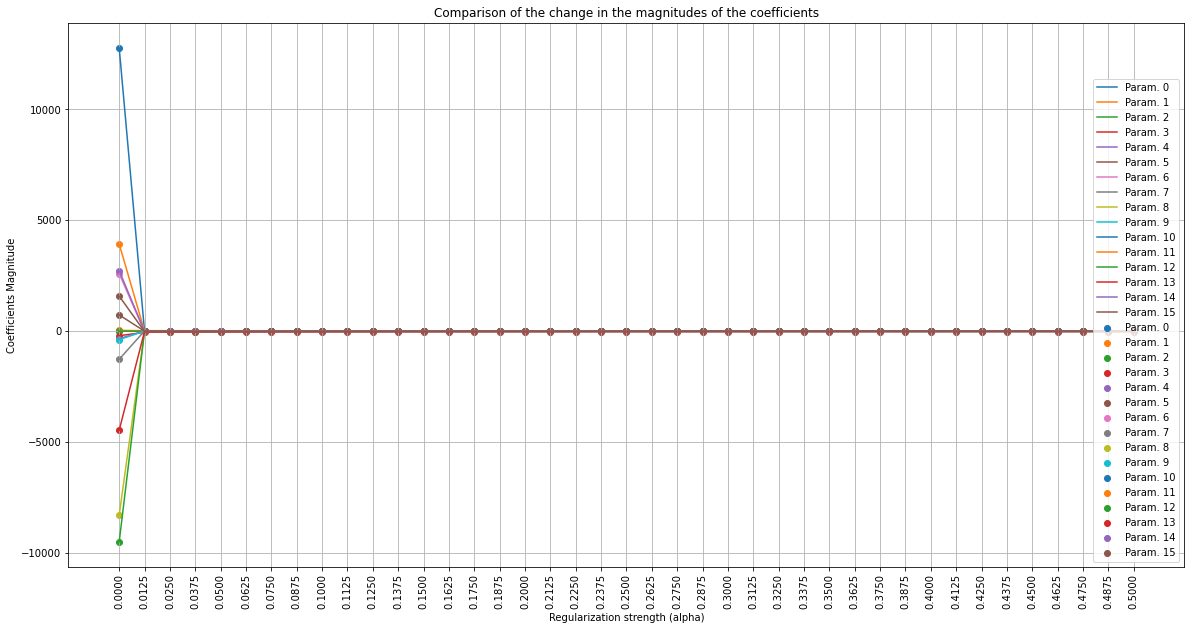

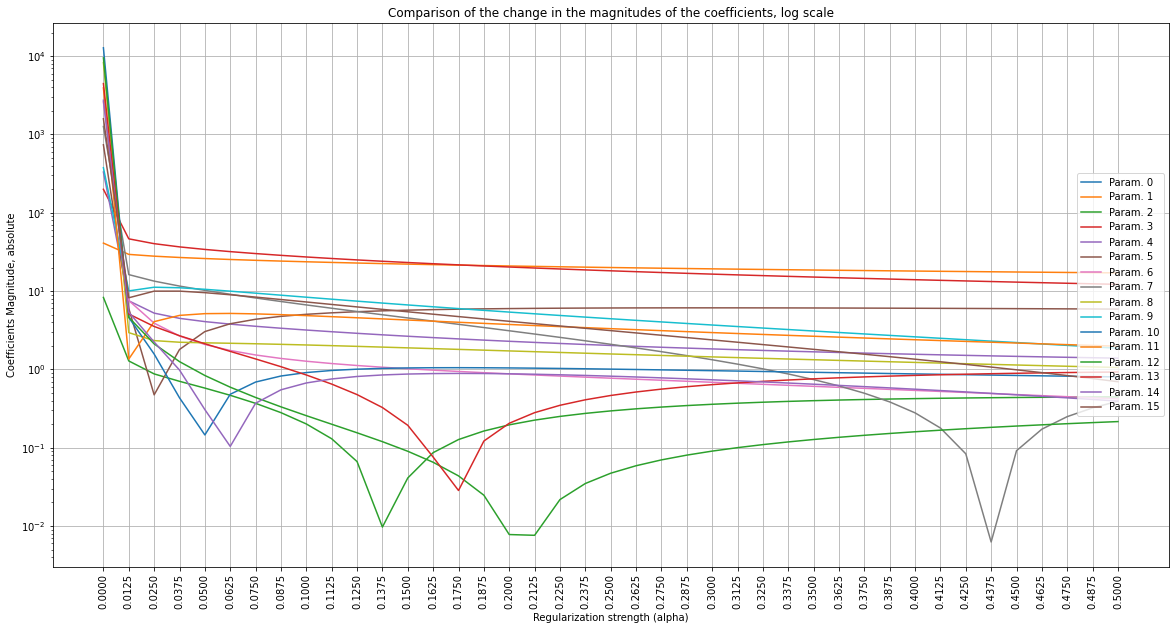

In [545]:
rmse_trainL2, rmse_validL2, avg_coefL2 = [], [],[]
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_trainL2.append(abs(np.mean(results['train_score'])))
    rmse_validL2.append(abs(np.mean(results['test_score'])))
    help=[]
    for i in np.arange(0,16):
        help.append(np.mean([(model['reg'].coef_[i]) for model in results['estimator']]))
    avg_coefL2.append(help)
    
    
plot_fitting_graph(ALPHAS, rmse_trainL2, rmse_validL2, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')


avg_coefL2=np.transpose(avg_coefL2)
plot_graph(ALPHAS, avg_coefL2, title="Comparison of the change in the magnitudes of the coefficients, linear scale", xlabel='Regularization strength (alpha)',
           ylabel='Coefficients Magnitude', label='Param. ')      
for i in range(0,len(avg_coefL2)):
    plot_scatter(ALPHAS, avg_coefL2[i], title="Comparison of the change in the magnitudes of the coefficients", xlabel='Regularization strength (alpha)',ylabel='Coefficients Magnitude',
             label='Param. '+str(i))
plot_graph(ALPHAS, abs(avg_coefL2), title="Comparison of the change in the magnitudes of the coefficients, log scale",
           xlabel='Regularization strength (alpha)', ylabel='Coefficients Magnitude, absolute', label='Param. ',custom_scale='log')   

df2 = pd.DataFrame(data=avg_coefL2, index=np.arange(0,16), columns=ALPHAS.round(4))
display(df2)

# - best approximation

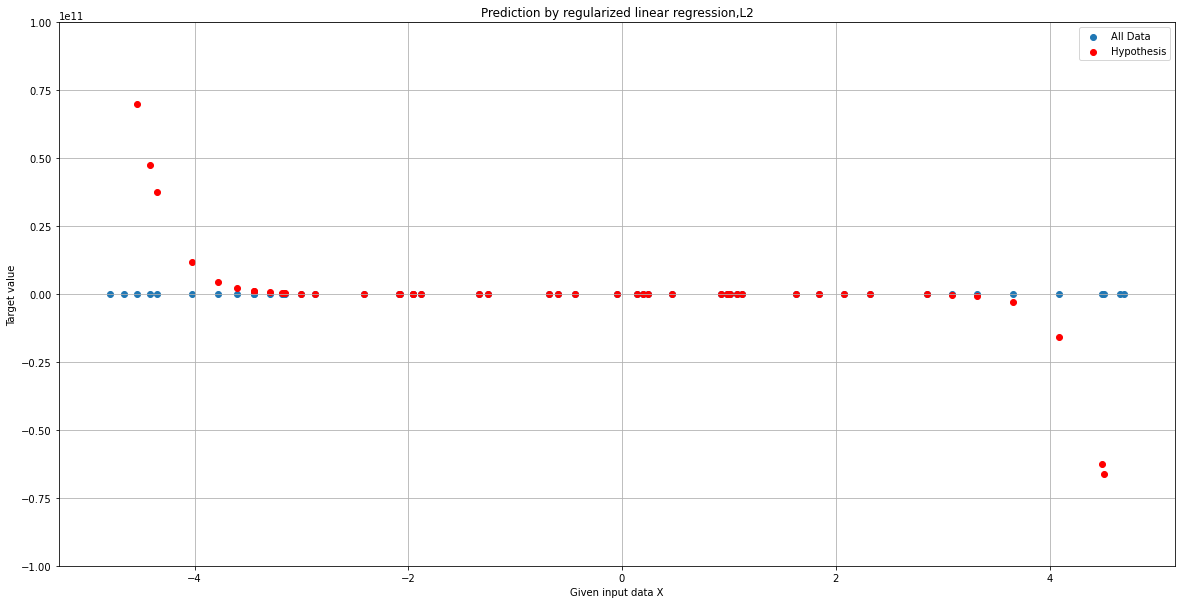

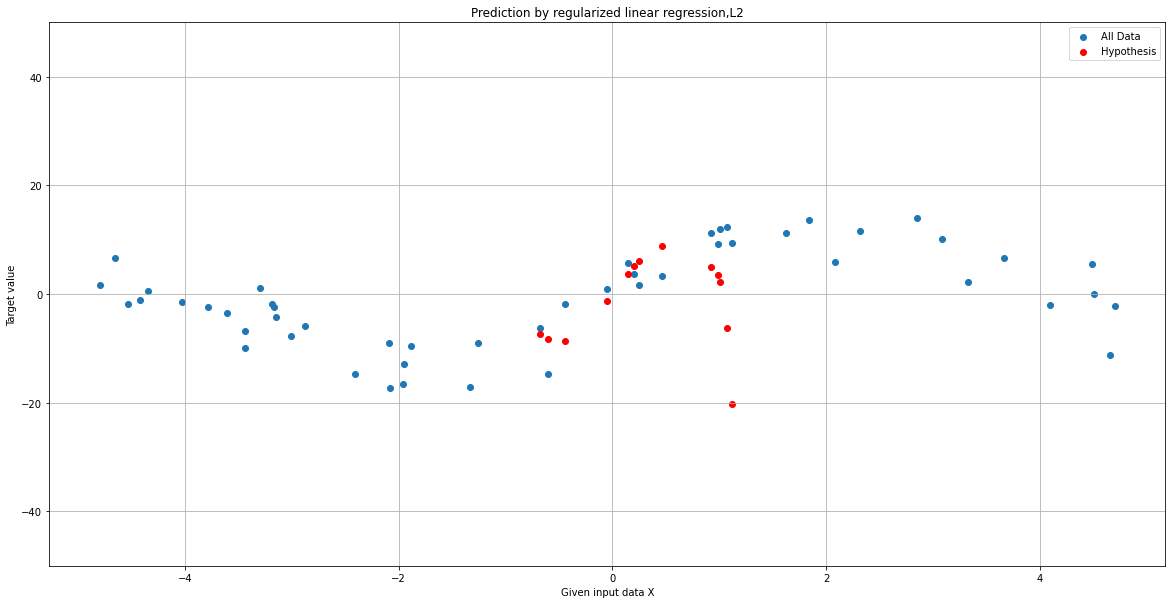

In [546]:
y_opt = np.empty(len(X), dtype=float)

for i in np.arange(0,len(X)):
    for deg in np.arange(0,len(avg_coefL2)):
         y_opt[i] = y_opt[i] + avg_coefL2[:,3][deg]*pow(X[i], deg)

plot_fit_optimal(y_opt, title='Prediction by regularized linear regression,L2',xlabel='Given input data X',
                 ylabel='Target value',min_y=-100000000000, max_y=+100000000000)# - best approximation

plot_fit_optimal(y_opt, title='Prediction by regularized linear regression,L2',xlabel='Given input data X',
                 ylabel='Target value',min_y=-50, max_y=+50)# - best approximatioOn, closer


#### Summary

In this exercise the degree of the polynominal without intercept that describes the target function is 15, lambdas(alphas, regularization parameters) are taken from the generated array from the settings. To compare the effect of the implementation of the regularization constraints, first I looked into the performance of the linear regression withour regularization, then with the L1 norm regularization, and, finally, with the L2 norm regularization

#### No regularization

 - To gain the optimal performance on these many describing parameters(50 samples and 15 parameters, there are too many variables) the training was conducted by cross validation (across 5 folds).
 - The resulting training score was 2.954768 and Validation score - 8.859732. Judging by the diagram above (on all the results for the different levels of complexity) the training score is the minimum among all the scores, however, the validation score is the maximum possible one. This situation is called overfitting as it has fitted the noise during the trainig of the model which skewed the model results. And even the cross validation - the use of all the data - did not significantly reduce the gigantic gap caused by the big weights of the parameters.
 - From the table above, we can see that the smallest weight we have for this model is about 8 for the x^2 parameter (which if calculated for x=4 already maxes out the maximum target y value), the largest coefficient is negative 9496 that characterizes x^12. The result is a big shift downwards that is afterwards compensated by other big coefficients. The model while in training goes in this way trying to fit as much as possible of the training data, destabilising and loosing the grip on its purpose of finding a generalized pattern to describe the input data.
 - Looking at the prediction (plotted above), achieved as the result of running linear regression model without additional regularization, we can say that the model failed to generalize and overfitted too much. The resulted target y is many times bigger than it was required to be.
 - If we zoom in on the plotted points it is noticable that only about a fifth of all the predictions made were in the general area that was needed, everything else is off the chart, predicted  as a value too big to even be shown on the diagram.

#### L1

  - From the performance over all the alphas in the range for the Lasso polynominal regression it can be said that the optimal parameter alpha is found at the value 0.0375. The validation score is at the minimum at this level (about 4.5), while the training score is about 3.8. At this alpha we can influence overfitting a bit, so that the results of the prediction would be more generalized. It is easy to notice that the validation score is almost twice smaller than for the regression without regularization. However, the training score is higher (not fitting the noise in as much as with the usual linear regression). 
  - Now let's look at the behaviour of the characteristics/weights with the change of the regularization parameter alpha. The higher it is the less the weight aim to be to minimize the error+penalty while training the model. The graph is a bit difficult to read because of the differences in the magnitudes of the values. The absolute highest weights are, of course, achieved with the alpha parameter equal to 0 (this is just a usual linear regression without implimentation of the penalty). After the implementation of the regularization with alpha not equal to 0 the weights abruptly decrease in their magnitude aiming for the values close to 0.
  - The comparison of the change in magnitude of the absolute values of the weights are better illustrated at the chart with log y scale. The most affluent parameters such as x^1 and x^3 are given the biggest weights. While most of the others either quickly zero out or near 0 with quite small values.
  - From the table we can see that, after the implementation of L1 regularization with alpha=0.0125, x^1, x^3, x^7 have the biggest coefficients in the range of the absolute numbers of [20, 39]. It's quite a big change in comparison with the thousands in the linear regression without regularization. For the degrees 5, 8, 10, 11, 12, 13 the weights competely zeroed out. Let's look at the alpha=0.0375. x^1, x^3, x^7 are still the most influential in the range of the absolute numbers of [14, 29]. The 9th weight zeroed out, while 13th rose slightly higher than 0. For the alpha=5, x^1, x^5 have the biggest weights of 9.5 and -6.7 - a great difference from the starting point. Only degrees 3 and 14 have the weights about 0, the others have became 0s.
  - Let's look at our optimal solution at alpha=0.0375. Some of our predictions are still quite big. But in comparison with the linear regression (the biggest at the level of 10^13-10^14) the results with the regularization (10^11-10^12) have improved in several times. However, in the closeup we can see that the amout of the points in the right area of the target is still quite small at about a fifth of the whole X set. 


#### L2
 - As we can see from the results of the plotting of the training and validation scores for the Ridge polynominal regression the minimum value of the validation scores is achieved at the alpha=0.1125. The  validation score is at about 4.7,  while the training score is at about 3.9. Thus, it's obvious that both of the scores are higher than for the Lasso regression (it is possible that the removal of some of the parameters let the L1 regularization improve the generalization and reduce overfitting). Though, in comparison with the regular linear regression, the validation scores are again better for the model with a regularization penalty.
 - It can be clearly seen from the linear representation of the change in the weights that in comparison with the usual linear regression the implementation of the constraints on the weights via the regularization parameter alpha causes the points to jump from their high values/magnitudes to the much lesser values. However, it does not give us an obvious insight into how the characteristics behave themselves while being so close to the 0 and after the application of the Ridge regression with the higher regularization parameter alpha.
 - The log y scale representation of the absolute values gives us a more detailed report on the changes in the magnitudes of the weights after the implementation of the Ridge regression with different levels of alphas. It's interesting to see that none of the weights throughout all the different levels of alphas do not lower themselves too close to 0 which is the opposite result to the Lasso regression where even a slight increase in alpha resulted in zeroing out of some of the parameters. Also, as in the Lasso regression  x^1 and x^3 parameters are assigned with the biggest weights. However, in this case almost a half of the weights are not that far behind in their magnitude throughout the change in the regularization parameter alpha.  
 - From the table we can see that, after the implementation of L2 regularization with the alpha=0.0125, x^1, x^3, x^7 have the biggest coefficients in the range of the absolute numbers of [16, 47], some of which are bigger than the coefficients that resulted from the implementation of L1 regularization with the same alpha. It's still a great leap from the thousands of the linear regression without regularization. In comparison with the Lasso regression with the same alpha none of the weights competely zeroed out, even more: their absolute weight value is not less than 1. Let's look at the alpha=0.1125. x^1, x^3 are still going strong in the range of the absolute numbers of [23, 25.1]. Several parameters (degrees equal to 2, 10, 12,13,14) have their absolute weight values less than 1. None have zeroed out.  The other parameter weights are in the range of [1,8]. For the alpha=5, x^1, x^3, x^5 have the biggest weights of 17.1, -12.2 and -6 correspondently - a great difference from the starting point. The other absolute parameter weights are in the range from 0.2 to 2. None have zeroed out.
 - Let's look at our optimal solution at the alpha=0.1125. Some of our predictions are still quite big. But in comparison with the linear regression (the biggest at the level of 10^13-10^14) the results of the model with the regularization (10^11-10^12) have improved in several times. However, in the closeup we can see that the amount of the points in the right area of the target is still quite small at about a fifth of the whole X. The results also look a bit familiar with the Lasso regression with the optimal alpha in both far away and closeup plotting (the Ridge regr. predicts the points lying  farther in comparison with the Lasso regression).

#### Comparison between linear regression alpha=0, and with addition of penalties L1 and L2

 - One of the intresting results of the plotting the predictions of different models is the alikeness of the results for the Rige and Lasso regressions with their corresponding alphas and their difference with the unregularized linear regression. The ones with the L1 and L2 regularizations go from the top left corner to the bottom right, while the linear regression without relularization does the opposite: from the bottom left to the top right. This is probably caused by the removal or lessening of the influence of a feature/features with high degree/degrees. Though not on the right scale, the regularized models mimic the behaviour of the target parameter. 
 - From the results and description above it can be noticed that alphas influences the regressions with regularizations differently. Linear regression updates its weights influenced by the minimization of the error (w = w - H). While the Ridge regression with its optimisation first shrinks the weight (the higher the alpha the more it is shrinked: w = w*(1-2*alpha)-H) then subtracts additianal value to minimize the error (H), the Lasso directly subtracts the alpha according the sign of the weight (if the w is positive, alpha is substracted to get closer to 0: w = w - alpha - H, if the w is negative: w = w + alpha - H) from the weight then it subtracts additianal value to minimize the error(H). As it can be seen in both of the cases with the regularizations with alphas not equal to 0, the w decreases faster than for the usual lin.reg. (moving w closer to the 0 in the case of Lasso and shrinking it in the case of the Ridge - before the substraction of the H) due to the additional effort to minimize the corresponding penalties along with the error minimization.
 
 As you can see from the emperical evidence above the regularization helps to generalize the description of the target value by shrinking the corresponding weights of the parameters. Penalty to the sum of the weights leads to the optimal distribution of the weights. Most of the 'resource' will go to the simple features that describe most of the variance, while the complex features will get small/zero weight.  

### Excercise 2 - Sparsity (4 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

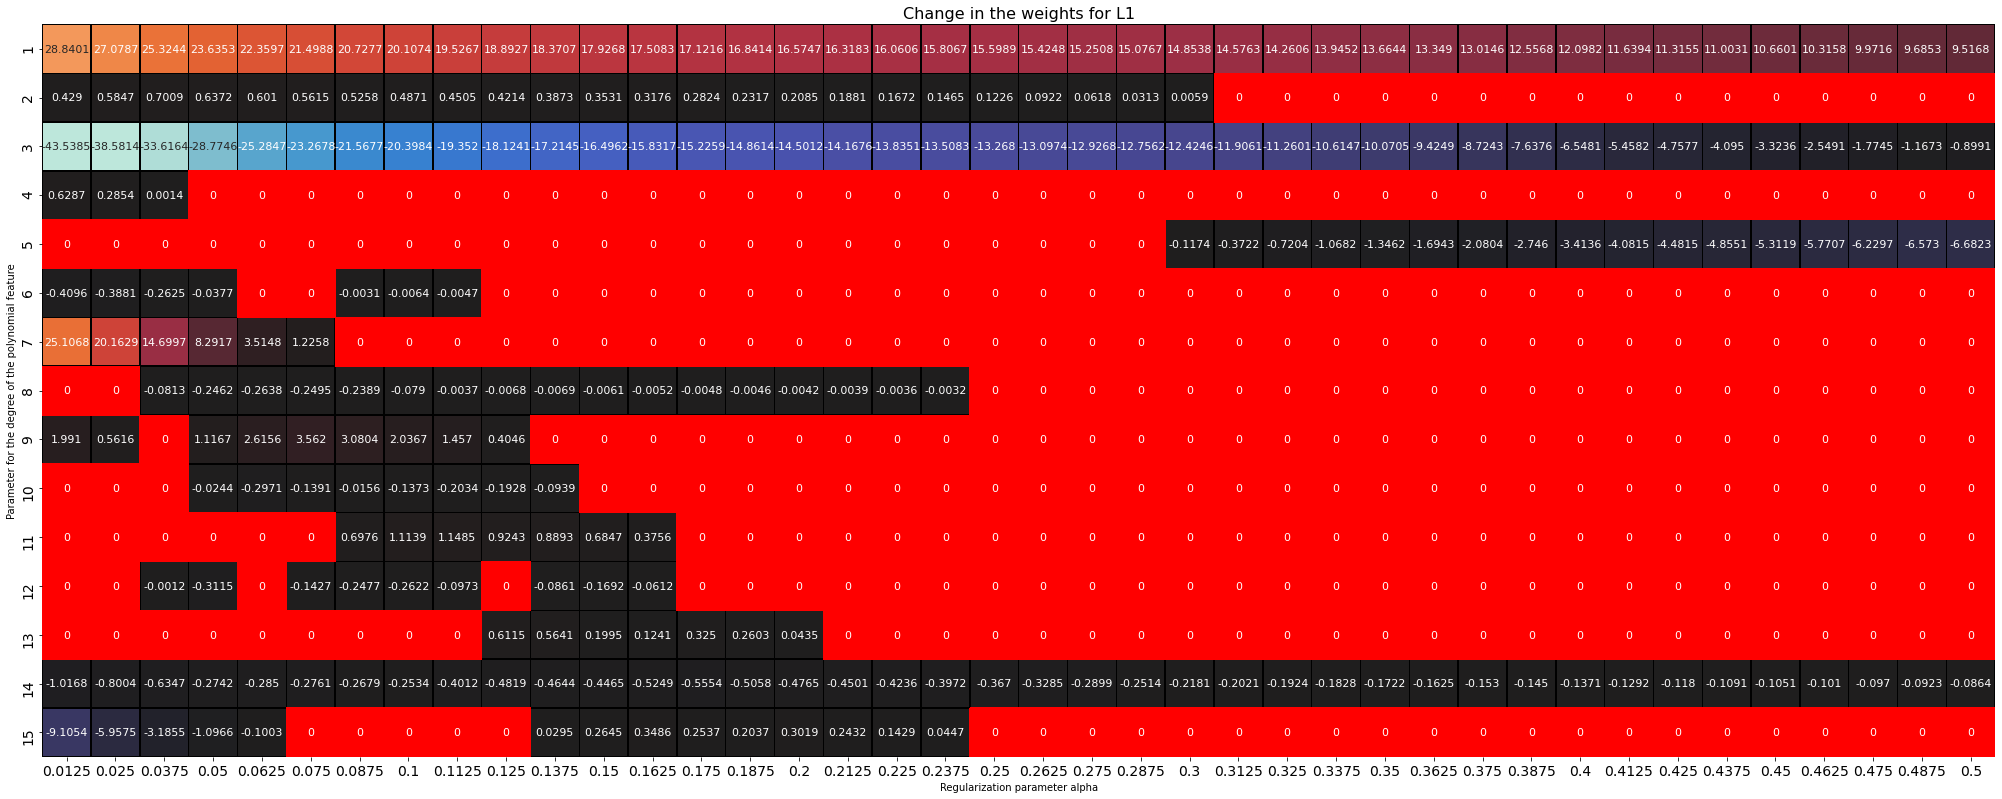

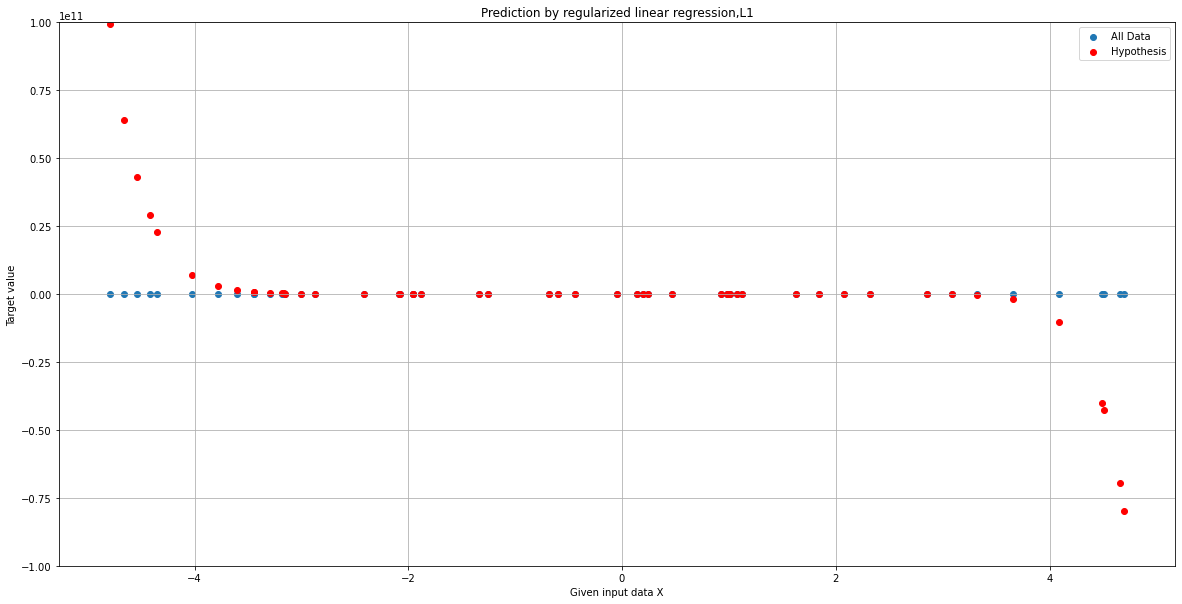

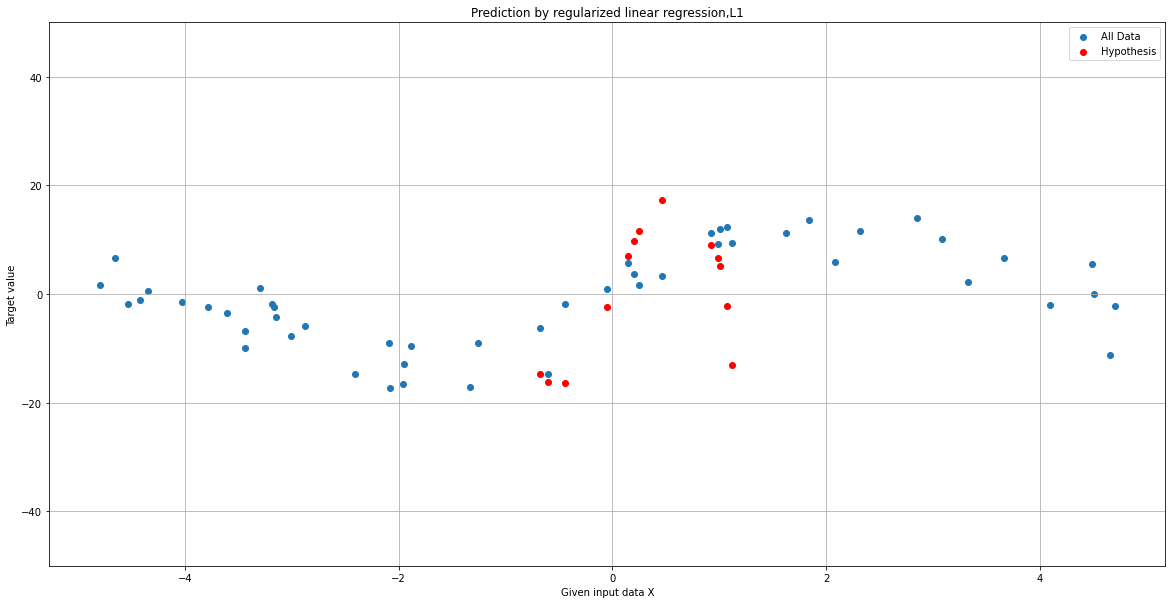

In [547]:
df1 = round(df1, 4)

plt.figure(figsize=(35,25))
cmap1 = mpl.colors.ListedColormap(['r'])
sns.heatmap(df1.iloc[1:,1:], annot=True,annot_kws={"size":11},linewidths=0.5, linecolor='black', center=0, fmt="g",vmin=-35, vmax=35,square=True, cbar=False)
sns.heatmap(df1.iloc[1:,1:], mask=abs(df1.iloc[1:,1:]) > 0.001, cmap=cmap1, cbar=False)

plt.title('Change in the weights for L1', fontsize=16)
plt.xlabel("Regularization parameter alpha")
plt.ylabel("Parameter for the degree of the polynomial feature")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


nz = df1.iloc[:,3]
mask = abs(nz.values) >0.01

y_opt = np.empty(len(X), dtype=float)

for i in np.arange(0,len(X)):
    for deg in np.arange(0,len(avg_coefL1)):
        if mask[deg]==True:
            y_opt[i] = y_opt[i] + avg_coefL1[:,3][deg]*pow(X[i], deg)

plot_fit_optimal(y_opt, title='Prediction by regularized linear regression,L1',xlabel='Given input data X',
                 ylabel='Target value',min_y=-100000000000, max_y=+100000000000)# - best approximation

plot_fit_optimal(y_opt, title='Prediction by regularized linear regression,L1',xlabel='Given input data X',
                 ylabel='Target value',min_y=-50, max_y=+50)# - best approximatioOn, closer



#### L2

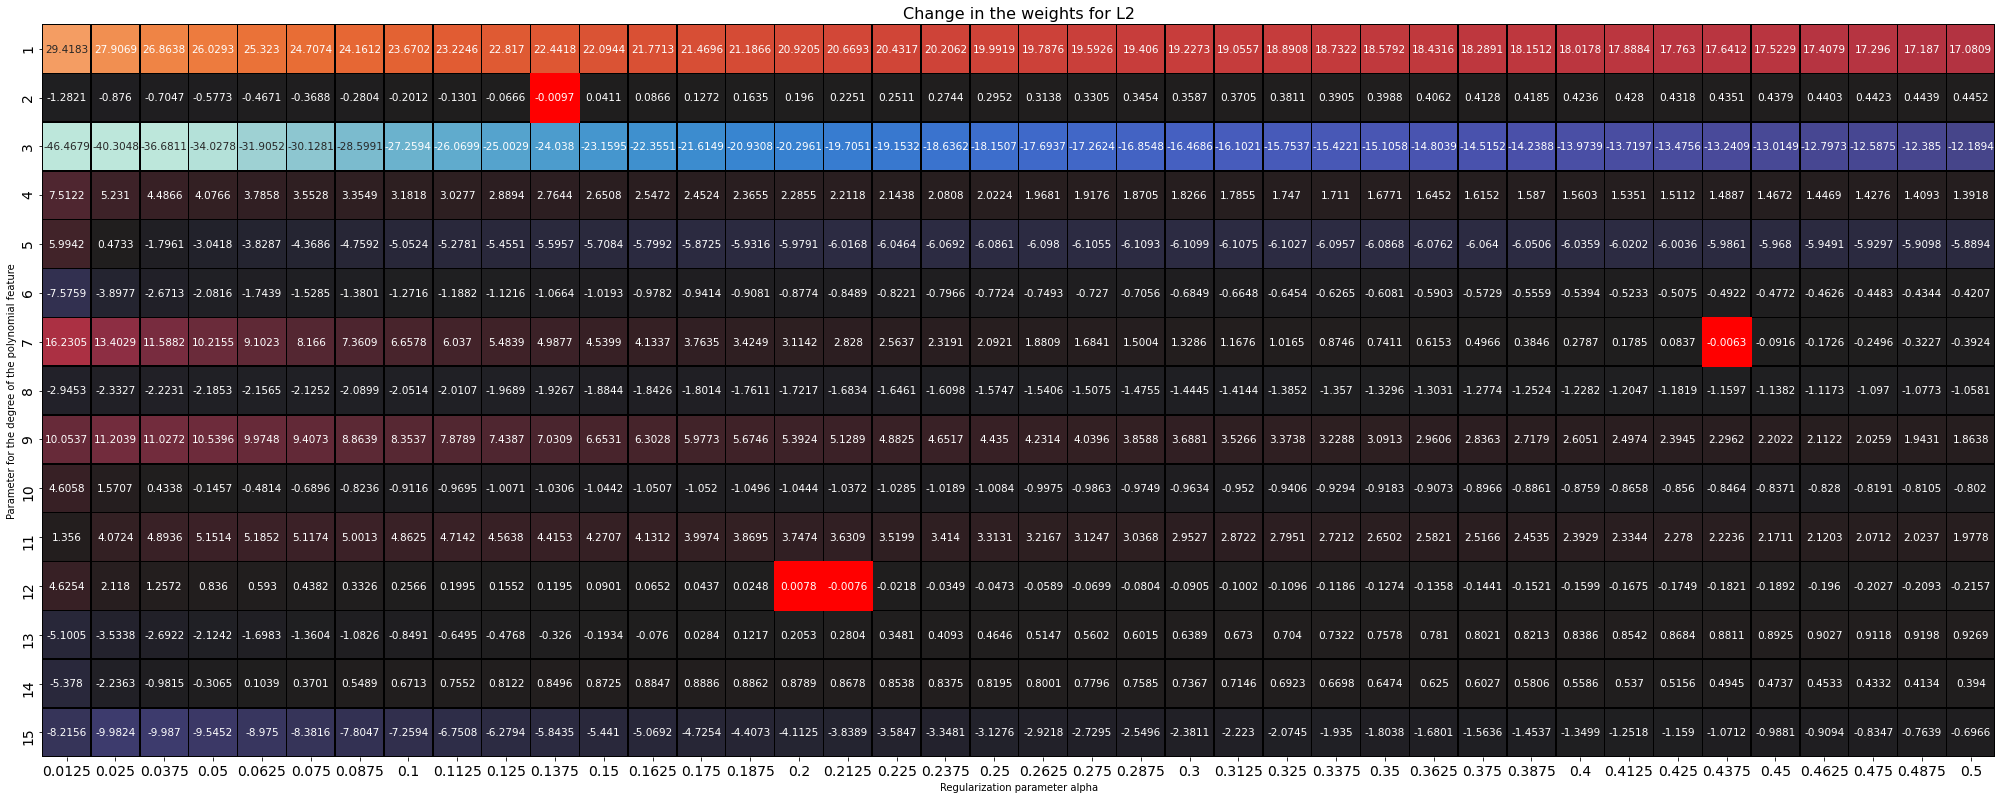

[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


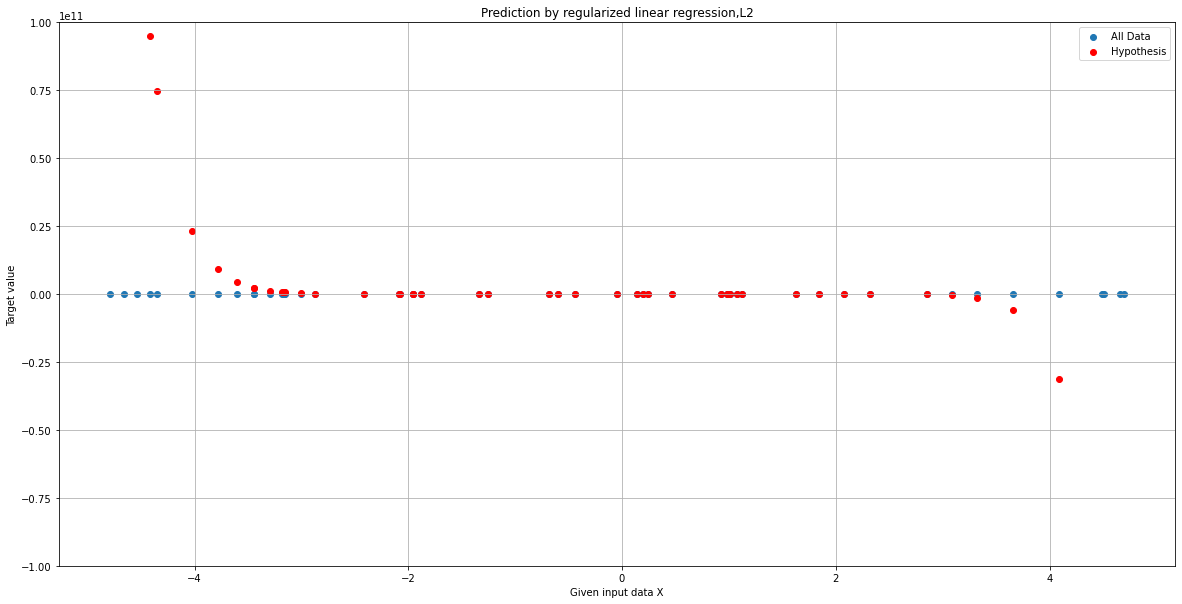

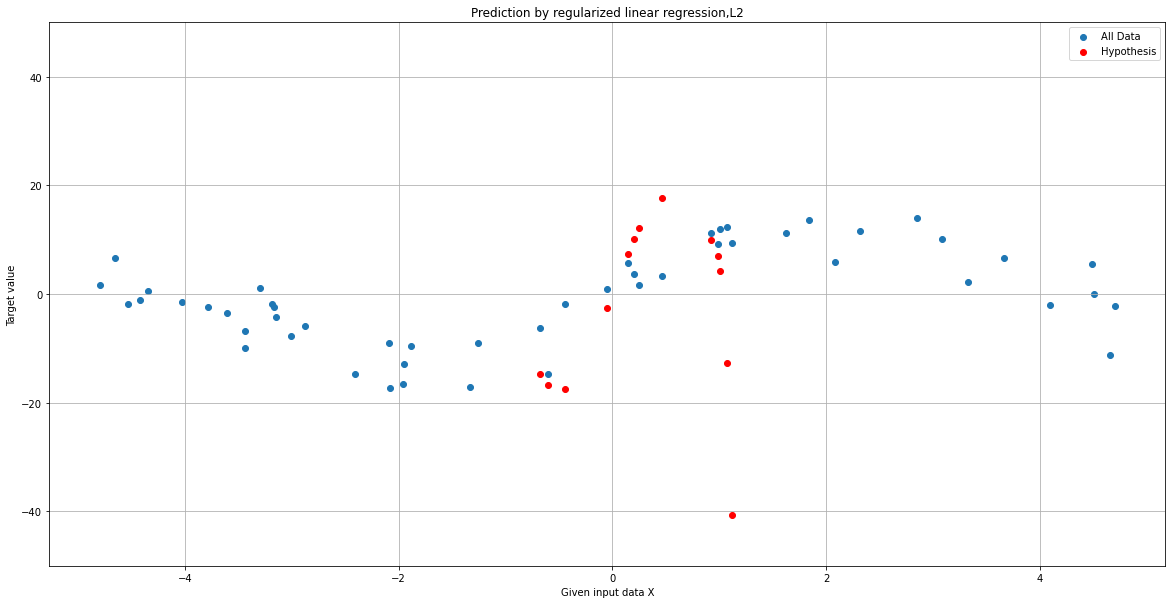

In [548]:
df2 = round(df2, 4)

plt.figure(figsize=(35,25))
cmap1 = mpl.colors.ListedColormap(['r'])
sns.heatmap(df2.iloc[1:,1:], annot=True,annot_kws={"size":10.5},linewidths=0.5, linecolor='black', center=0, fmt="g",vmin=-35, vmax=35,square=True, cbar=False)
sns.heatmap(df2.iloc[1:,1:], mask=abs(df2.iloc[1:,1:]) > 0.01, cmap=cmap1, cbar=False)

plt.title('Change in the weights for L2', fontsize=16)
plt.xlabel("Regularization parameter alpha")
plt.ylabel("Parameter for the degree of the polynomial feature")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

nz = df2.iloc[:,3]
mask = abs(nz.values) >0.01
print(mask)
y_opt = np.empty(len(X), dtype=float)

for i in np.arange(0,len(X)):
    for deg in np.arange(0,len(avg_coefL1)):
        if mask[deg]==True:
            y_opt[i] = y_opt[i] + avg_coefL2[:,3][deg]*pow(X[i], deg)

plot_fit_optimal(y_opt, title='Prediction by regularized linear regression,L2',xlabel='Given input data X',
                 ylabel='Target value',min_y=-100000000000, max_y=+100000000000)# - best approximation

plot_fit_optimal(y_opt, title='Prediction by regularized linear regression,L2',xlabel='Given input data X',
                 ylabel='Target value',min_y=-50, max_y=+50)# - best approximatioOn, closer


#### Summary

The matrices with the coefficients for every regularization parameter alpha for the both of the cases of the Lasso regression and the Ridge regression are represented in the forms of heatmaps, where the bright red color means that the corresponding feature's coefficient for that alpha is less than a certain subjectively chosen boundary and could be selected not to be included in the further analysis. The alpha=0 is not shown on the heatmap to decrease the range of the possible w and guarantee more colorful representation of the change in the weight coefficients. Also the row for the degree=0 is taken out of the heatmap (they are all equal to 0, as there is no intercept). The results of the removal of some features is illustrated beneath each heatmap correspondingly to study the effect on the model's prediction ability.

#### L1

* As it has been already observed a lot of coeffitients turn 0 quite quickly and starting from alpha=0.3125 there are only 4 parameters that can be taken for the description of the target value - it is natural feature selection - as all the others are just multiplied by 0 and ignored. For the description of the target value with the Lasso regression with alpha =0.0125, only the weight parameters for the degrees 1, 2, 3, 4, 6, 7, 9, 14, 15 will do. For the description of the target value with the Lasso regression with alpha =0.0375, only the weight parameters for the degrees 1, 2, 3, 4, 6, 7, 8,12,14, 15 will do. It's interesting that throughout all the models with all the alphas (leading to the tightening of the constraints on the weights, decreasing them) the features X^1 and X^3 remained - maiby it is the kind of  the simple explanation a regularization is applied for. To reduce overfitting and improve generalisation. It could also be noticed that the parameters for the most of the features with big degrees are either quickly turned to 0 or reduced to quite small weights.
* The boundary for the ban on the selection of the feature was chosen to be 0.01. As you can see, it hasn't influenced the choice of the features in any case of the alpha, because they were already equal to 0, and, thus, ingnored after the multiplication on the corresponding feature. 
* As it can be seen from the 2 plots beneath the heatmap the plot for the optimal alpha=0.0375 have not changed at all.


#### L2

* As it has been already observed none of the coefficients turn 0, and though some come close, it is not quite enough to decide whether or not the feature should definitly leave.The boundary for the ban on the selection of a feature in this case has been chosen to be 0.01. As you can see, it hasn't influenced the choice of the features in most of the cases of the alpha, because they were bigger than the boundary. So the multiplication of the weights on the corresponding features would go smoothly. There are exceptions that were caught under the boundary and became a subject of consideration. These are: alpha=0.1375, degree=2; alpha=0.2, degree=12; alpha=0.2125, degree=12; alpha=0.4375, degree=7.It depends on a person whether to include them into the further analysis, ot consider the results enough to remove the features.
* It can be noticed that for the description of the target value with the Ridge regression with alpha =0.0125, the weight parameters for the degrees 1,  3, 4, 5, 6, 7, 9, 13, 14, 15 have high weights. For the description of the target value with the Ridge regression with alpha =0.1125, the weight parameters for the degrees 1,3, 7,  9, 15 have high weights. And for the alpha=0.5 only the weights of the 1st, 3d,and 5th are considered to be important enought to be emphasized. It seems both the Lasso and the Ridge regressions consider these features important. It could also be noticed that the parameters for the most of the features with big degrees have diminished significantly with the increase of the alpha.
* As it can be seen from the 2 plots beneath the heatmap the plots for the optimal alpha=0.1125 have not changed at all as they have not prohibitted any features.


From the results above we can definetly conclude that Lasso regression can be used for the feature selection because it is more likely to produce zero coefficients. It seems that the features with the degrees 1,3,5 are significant as they are the only ones that hold their ground and decreasing slower throughout the process of the alpha selection in both of the models with regularizations.


### Excercise 3 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Why is scaling important? What are the underlying reasons?

#### - What is scaling and where is it used?
   (Feature) Scaling is a method used to normalize the range of independent variables or features of data. It is usually performed during  the data preprocessing step. The most common techniques of feature scaling are Normalization and Standardization. Normalization is used to bind the values between two numbers, typically, between [0,1] or [-1,1]. Standardization transforms the data to have the mean equal to 0 and the variance - to 1. 

#### - Why is scaling important? 
   In case when one of the features has a broad range or high values, the impact of this column will be much higher as compared to the impact of low valued columns. The feature with high magnitude will weigh lot more than features having low magnitude even if they are better used for the determination of the output. The algorithm may get insensitive to the columns having lower ranges and might lead to inconsistencies and wprsening of the expected prediction results.
   * Regression Coefficients are directly influenced by the scale of the features
   * Features with higher scale dominates over lower scale features without scaling
   * Some of the algorithms reduce time of execution, if scaled (gradient descent converges much faster with feature scaling than without it).
   * Some algorithms are very sensitive to the feature scaling since they are dependent on distance and Gaussian curves. Algorithms that do not require normalization/scaling are the ones that rely on rules(“Tree-Based” algorithm).
   * If regularization is used as part of the loss function, the coefficients are penalized appropriately (according to the weights that depend on the range and magnitude of the feature data).

#### - What about the coefficient estimate?
   As for the standard least squares coefficient estimate, it is scale equivalent. If a X_j multiplyed by a constant C it leads to the scaling of the least squares coefficient estimates by a factor of 1/c. And regardless of how jth feature is scaled, X_j * w_j stays the same. However if we look at the Ridge regression coefficient estimate, it can change significantly when X_j is multiplyed by a constant C due to the penalty part of the ridge regression function - the sum of the squared coefficients.
   
#### - What are the underlying reasons?
   When the range of values are very distinct and different in each column, they are needed to be scaled to the common ground.The features should be accounted for not because of their size but based on their right important description of the target value. The describing features usually do not look the same unless they are made to be similar in some context to compare their attributes. We need to do scaling so that one significant number doesn’t impact the model just because of their large magnitude. The machine/algorithm would see just number not knowing what it means, and as the result these bigger numbers starts playing a more decisive role while training the model. After the scaling is done the features could be assigned more easily understandable weights (in response to the importance of the feature). All features should be on the same scale (it could bring about faster convergence, and more uniform, fair influence on all the weights).

#### - On what part of the given data is it used?
   The scaler must applied to the training sample, and only after that to the test sample. If the scaler was fit on the test sample and then applied to the train sample it could lead to the data leakage. If different scalers are used for the train and test samples it would result in some random skew in the data.





